In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import geopandas
import plotly.express as px
import os
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import imageio
import mapclassify
import matplotlib
import matplotlib.image as mpimg
import ast
import json
import numpy as np
import shapely.wkt
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import matplotlib
pd.set_option('display.max_columns', None)
from six.moves import reduce
import scipy
from sklearn.metrics import r2_score
#scipy.stats.pearsonr
import scipy.stats as stats
plt.rcParams.update({'font.family': 'Arial'})
import matplotlib.colors as clr
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from sklearn.cluster import *
from sklearn.decomposition import PCA
from functools import reduce
import scipy.stats

import math
import sklearn
import sklearn.feature_extraction.text
from sklearn import cluster
from sklearn import metrics
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.decomposition
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.metrics import roc_auc_score
from shapely import wkt
#from mycolorpy import colorlist as mcp
import matplotlib.ticker as mtick
from  matplotlib.colors import LinearSegmentedColormap
from functools import reduce
import matplotlib.ticker as plticker
from PIL import Image

In [2]:
param_2018 = pd.read_csv(
    'data/3_PSO_results/PSO_calirabtion_results/norm_PSO_combination_2018/PSO_2018_6params_NYC_norm_28_PSO_15.csv')

param_2019 = pd.read_csv(
    'data/3_PSO_results/PSO_calirabtion_results/norm_PSO_combination_2019/PSO_2019_6params_NYC_norm_28_PSO_15.csv')

param_2020 = pd.read_csv(
    'data/3_PSO_results/PSO_calirabtion_results/norm_PSO_combination_2020/PSO_2020_6params_NYC_norm_28_PSO_15.csv')

param_2021 = pd.read_csv(
    'data/3_PSO_results/PSO_calirabtion_results/norm_PSO_combination_2021/PSO_2021_6params_NYC_norm_28_PSO_15.csv')

In [3]:
dfs = {'param_2018': param_2018,'param_2019': param_2019,'param_2020': param_2020, 'param_2021': param_2021}

In [4]:
vars_definition = {'H_Area_of_store': 'Store area', 
       'R_Percentage_of_Visits_by_brand': 'Chain loyalty', 'J_POI_count_where_store_is': 'POI count',
       'K_POI_diversity_where_store_is': 'POI diversity', 'L_Demographic_similarity': 'Demographic similarity',
       'G_Distance_between_cbg_and_store':'CBG-Store Distance'}

In [5]:
variables = ['H_Area_of_store', 
       'R_Percentage_of_Visits_by_brand', 'J_POI_count_where_store_is',
       'K_POI_diversity_where_store_is', 'L_Demographic_similarity',
       'G_Distance_between_cbg_and_store']

In [6]:
for v in variables:
    param_2018 = param_2018.rename(columns = {v: v + '_2018'})
    param_2019 = param_2019.rename(columns = {v: v + '_2019'})
    param_2020 = param_2020.rename(columns = {v: v + '_2020'})
    param_2021 = param_2021.rename(columns = {v: v + '_2021'})

In [7]:
param_2018 = param_2018.drop(columns = ['cost'])
param_2019 = param_2019.drop(columns = ['cost'])
param_2020 = param_2020.drop(columns = ['cost'])
param_2021 = param_2021.drop(columns = ['cost'])

In [8]:
params_as_of_2020 = param_2018[~param_2018.isin(['no visitors']).any(axis=1)].merge(
    param_2019[~param_2019.isin(['no visitors']).any(axis=1)], on = 'cbg').merge(
        param_2020[~param_2020.isin(['no visitors']).any(axis=1)], on = 'cbg')
params_as_of_2021 = param_2019[~param_2019.isin(['no visitors']).any(axis=1)].merge(
    param_2020[~param_2020.isin(['no visitors']).any(axis=1)], on = 'cbg').merge(
    param_2021[~param_2021.isin(['no visitors']).any(axis=1)], on = 'cbg')

In [9]:
for c in params_as_of_2020.columns:
    if '2018' in c or '2019' in c or '2020' in c:
        params_as_of_2020[c] = params_as_of_2020[c].astype(float)

In [10]:
for c in params_as_of_2021.columns:
    if '2019' in c or '2020' in c or '2021' in c:
        params_as_of_2021[c] = params_as_of_2021[c].astype(float)

In [11]:
params_as_of_2020.shape

(5502, 19)

In [12]:
params_as_of_2021.shape

(5502, 19)

In [13]:
ses = ['med_ageE','bachelor_degree_25E', 'med_hh_incomeE', 'whiteE', 'blackE', 'asianE','hispanicE']

In [14]:
for v in variables:
    params_as_of_2020[v + '_delta'] = (params_as_of_2020[v+'_2020'] - params_as_of_2020[v+'_2019']) - (
        params_as_of_2020[v+'_2019'] - params_as_of_2020[v+'_2018'])
    params_as_of_2021[v + '_delta'] = (params_as_of_2021[v+'_2021'] - params_as_of_2021[v+'_2020']) - (
        params_as_of_2021[v+'_2020'] - params_as_of_2021[v+'_2019'])

# Top 5% SES factors

In [16]:
delta_means = {'2020': {}, '2021': {}}
for i in variables:
    delta_means['2020'][i] = params_as_of_2020[i + '_delta'].mean()
    delta_means['2021'][i] = params_as_of_2021[i + '_delta'].mean()

In [17]:
delta_means

{'2020': {'H_Area_of_store': 3.319064893815986,
  'R_Percentage_of_Visits_by_brand': 2.83126260154467,
  'J_POI_count_where_store_is': 1.1000170839917147,
  'K_POI_diversity_where_store_is': 0.7718708013098982,
  'L_Demographic_similarity': 0.2226297722296855,
  'G_Distance_between_cbg_and_store': -2.3445031755816057},
 '2021': {'H_Area_of_store': -3.2497586798210993,
  'R_Percentage_of_Visits_by_brand': -2.800300406228069,
  'J_POI_count_where_store_is': -0.4255057322505557,
  'K_POI_diversity_where_store_is': -0.578535481840873,
  'L_Demographic_similarity': -0.21478142782139398,
  'G_Distance_between_cbg_and_store': 1.0860262653950885}}

In [18]:
census = pd.read_csv('data/1_data_for_extracting_information/NY_cbg_census.csv').rename(
    columns = {'GEOID':'cbg'})

In [19]:
def get_pro(part):
    total_list = census.populationE.tolist()
    part_list = census[part].tolist()
    ans = []
    for i,num in enumerate(total_list):
        if num == 0:
            ans.append(0)
        else:
            ans.append(part_list[i]/num)
    return ans

change = ['bachelor_degree_25E', 'whiteE', 'blackE', 'asianE', 'hispanicE']
for i in change:
    census[i] = get_pro(i)

In [20]:
params_as_of_2020 = params_as_of_2020.merge(census[['cbg']+ses], how = 'inner').dropna()
params_as_of_2021 = params_as_of_2021.merge(census[['cbg']+ses], how = 'inner').dropna()

In [21]:
params_as_of_2020

,cbg,H_Area_of_store_2018,R_Percentage_of_Visits_by_brand_2018,J_POI_count_where_store_is_2018,K_POI_diversity_where_store_is_2018,L_Demographic_similarity_2018,G_Distance_between_cbg_and_store_2018,H_Area_of_store_2019,R_Percentage_of_Visits_by_brand_2019,J_POI_count_where_store_is_2019,K_POI_diversity_where_store_is_2019,L_Demographic_similarity_2019,G_Distance_between_cbg_and_store_2019,H_Area_of_store_2020,R_Percentage_of_Visits_by_brand_2020,J_POI_count_where_store_is_2020,K_POI_diversity_where_store_is_2020,L_Demographic_similarity_2020,G_Distance_between_cbg_and_store_2020,H_Area_of_store_delta,R_Percentage_of_Visits_by_brand_delta,J_POI_count_where_store_is_delta,K_POI_diversity_where_store_is_delta,L_Demographic_similarity_delta,G_Distance_between_cbg_and_store_delta,med_ageE,bachelor_degree_25E,med_hh_incomeE,whiteE,blackE,asianE,hispanicE
0,360050359001,5.246015,2.696207,3.122337,9.002946,13.590317,14.482521,3.006695,1.494385,1.419485,3.797733,4.733461,13.782162,5.788361,5.957322,4.922220,7.013178,12.599721,13.700481,5.020985,5.664759,5.205586,8.420658,16.723117,0.618678,37.2,0.033924,25490.0,0.126582,0.255696,0.023797,0.780759
1,360050167001,3.484115,6.865978,3.043939,5.076393,5.885937,13.818760,10.180718,6.496394,1.155854,3.200347,5.657573,8.191417,6.872050,5.456318,2.625326,9.352783,7.219817,4.709811,-10.005272,-0.670492,3.357556,8.028483,1.790607,2.145738,34.9,0.112130,44095.0,0.089704,0.583078,0.000000,0.489297
2,360050380001,4.061300,8.443326,2.686090,7.788213,3.243433,5.072445,1.063620,1.166777,10.101535,4.025973,2.945858,8.280659,4.110065,9.719363,14.959471,2.081618,3.478173,3.327997,6.044124,15.829136,-2.557509,1.817885,0.829889,-8.160877,47.4,0.322392,52500.0,0.047411,0.731583,0.070022,0.253829
3,360050216023,3.714461,2.072708,5.624411,3.097414,10.325657,11.735782,2.368854,1.856681,6.416469,1.687351,13.212280,12.517824,10.030794,7.073620,4.226680,10.546506,10.429080,13.413297,9.007548,5.432964,-2.981848,10.269217,-5.669824,0.113430,37.7,0.198389,56593.0,0.266638,0.457397,0.150064,0.394235
5,360050175002,9.212299,10.432316,1.028254,3.193695,2.867384,7.219378,3.574152,8.072461,1.991579,5.186959,7.220380,9.387443,8.133506,13.010066,1.436489,8.606823,9.140740,12.551116,10.197501,7.297460,-1.518416,1.426600,-2.432636,0.995609,25.9,0.031008,26250.0,0.080103,0.285960,0.000000,0.873385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5496,360610216001,1.829597,4.396730,2.667821,3.054830,2.551595,5.440588,5.929137,13.059571,6.910566,6.896101,2.452622,13.848163,13.365138,6.589028,1.884625,14.818171,13.439658,13.809842,3.336461,-15.133384,-9.268685,4.080800,11.086008,-8.445896,36.6,0.384012,74474.0,0.310446,0.522315,0.084846,0.112800
5497,360610232002,1.159310,2.093550,2.762358,14.488684,8.538428,3.463264,1.337955,1.294493,3.032042,1.703566,6.291227,8.752129,7.458753,13.943470,3.751879,4.432492,4.845625,3.577824,5.942153,13.448033,0.450153,15.514044,0.801598,-10.463170,26.6,0.101899,40372.0,0.117239,0.704894,0.030314,0.385318
5499,360610230003,4.676635,5.339577,9.744759,12.365080,5.368428,9.869766,1.186292,12.980089,2.652398,9.679309,6.184592,7.855816,14.668394,4.543128,2.049245,8.765637,13.191991,4.488383,16.972446,-16.077472,6.489209,1.772098,6.191236,-1.353484,35.1,0.226756,53684.0,0.163211,0.618729,0.000000,0.222742
5500,360610124002,1.026058,11.222001,1.696121,6.615158,10.618627,13.489773,1.197221,4.385812,2.613693,4.491627,10.628075,8.310084,14.609226,5.900432,3.260373,13.168549,14.724945,6.735283,13.240843,8.350810,-0.270893,10.800454,4.087422,3.604888,39.2,0.732729,107237.0,0.958097,0.000000,0.041903,0.050396


In [22]:
delta_means['2020']

{'H_Area_of_store': 3.319064893815986,
 'R_Percentage_of_Visits_by_brand': 2.83126260154467,
 'J_POI_count_where_store_is': 1.1000170839917147,
 'K_POI_diversity_where_store_is': 0.7718708013098982,
 'L_Demographic_similarity': 0.2226297722296855,
 'G_Distance_between_cbg_and_store': -2.3445031755816057}

In [25]:
params_as_of_2020

,cbg,H_Area_of_store_2018,R_Percentage_of_Visits_by_brand_2018,J_POI_count_where_store_is_2018,K_POI_diversity_where_store_is_2018,L_Demographic_similarity_2018,G_Distance_between_cbg_and_store_2018,H_Area_of_store_2019,R_Percentage_of_Visits_by_brand_2019,J_POI_count_where_store_is_2019,K_POI_diversity_where_store_is_2019,L_Demographic_similarity_2019,G_Distance_between_cbg_and_store_2019,H_Area_of_store_2020,R_Percentage_of_Visits_by_brand_2020,J_POI_count_where_store_is_2020,K_POI_diversity_where_store_is_2020,L_Demographic_similarity_2020,G_Distance_between_cbg_and_store_2020,H_Area_of_store_delta,R_Percentage_of_Visits_by_brand_delta,J_POI_count_where_store_is_delta,K_POI_diversity_where_store_is_delta,L_Demographic_similarity_delta,G_Distance_between_cbg_and_store_delta,med_ageE,bachelor_degree_25E,med_hh_incomeE,whiteE,blackE,asianE,hispanicE
0,360050359001,5.246015,2.696207,3.122337,9.002946,13.590317,14.482521,3.006695,1.494385,1.419485,3.797733,4.733461,13.782162,5.788361,5.957322,4.922220,7.013178,12.599721,13.700481,5.020985,5.664759,5.205586,8.420658,16.723117,0.618678,37.2,0.033924,25490.0,0.126582,0.255696,0.023797,0.780759
1,360050167001,3.484115,6.865978,3.043939,5.076393,5.885937,13.818760,10.180718,6.496394,1.155854,3.200347,5.657573,8.191417,6.872050,5.456318,2.625326,9.352783,7.219817,4.709811,-10.005272,-0.670492,3.357556,8.028483,1.790607,2.145738,34.9,0.112130,44095.0,0.089704,0.583078,0.000000,0.489297
2,360050380001,4.061300,8.443326,2.686090,7.788213,3.243433,5.072445,1.063620,1.166777,10.101535,4.025973,2.945858,8.280659,4.110065,9.719363,14.959471,2.081618,3.478173,3.327997,6.044124,15.829136,-2.557509,1.817885,0.829889,-8.160877,47.4,0.322392,52500.0,0.047411,0.731583,0.070022,0.253829
3,360050216023,3.714461,2.072708,5.624411,3.097414,10.325657,11.735782,2.368854,1.856681,6.416469,1.687351,13.212280,12.517824,10.030794,7.073620,4.226680,10.546506,10.429080,13.413297,9.007548,5.432964,-2.981848,10.269217,-5.669824,0.113430,37.7,0.198389,56593.0,0.266638,0.457397,0.150064,0.394235
5,360050175002,9.212299,10.432316,1.028254,3.193695,2.867384,7.219378,3.574152,8.072461,1.991579,5.186959,7.220380,9.387443,8.133506,13.010066,1.436489,8.606823,9.140740,12.551116,10.197501,7.297460,-1.518416,1.426600,-2.432636,0.995609,25.9,0.031008,26250.0,0.080103,0.285960,0.000000,0.873385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5496,360610216001,1.829597,4.396730,2.667821,3.054830,2.551595,5.440588,5.929137,13.059571,6.910566,6.896101,2.452622,13.848163,13.365138,6.589028,1.884625,14.818171,13.439658,13.809842,3.336461,-15.133384,-9.268685,4.080800,11.086008,-8.445896,36.6,0.384012,74474.0,0.310446,0.522315,0.084846,0.112800
5497,360610232002,1.159310,2.093550,2.762358,14.488684,8.538428,3.463264,1.337955,1.294493,3.032042,1.703566,6.291227,8.752129,7.458753,13.943470,3.751879,4.432492,4.845625,3.577824,5.942153,13.448033,0.450153,15.514044,0.801598,-10.463170,26.6,0.101899,40372.0,0.117239,0.704894,0.030314,0.385318
5499,360610230003,4.676635,5.339577,9.744759,12.365080,5.368428,9.869766,1.186292,12.980089,2.652398,9.679309,6.184592,7.855816,14.668394,4.543128,2.049245,8.765637,13.191991,4.488383,16.972446,-16.077472,6.489209,1.772098,6.191236,-1.353484,35.1,0.226756,53684.0,0.163211,0.618729,0.000000,0.222742
5500,360610124002,1.026058,11.222001,1.696121,6.615158,10.618627,13.489773,1.197221,4.385812,2.613693,4.491627,10.628075,8.310084,14.609226,5.900432,3.260373,13.168549,14.724945,6.735283,13.240843,8.350810,-0.270893,10.800454,4.087422,3.604888,39.2,0.732729,107237.0,0.958097,0.000000,0.041903,0.050396


In [26]:
census_top_stats = params_as_of_2020.quantile(0.95)[ses].to_dict()
for k,v in census_top_stats.items():
    census_top_stats[k] = round(v, 2)
census_top_stats

{'med_ageE': 52.88,
 'bachelor_degree_25E': 0.67,
 'med_hh_incomeE': 144069.2,
 'whiteE': 0.92,
 'blackE': 0.89,
 'asianE': 0.55,
 'hispanicE': 0.78}

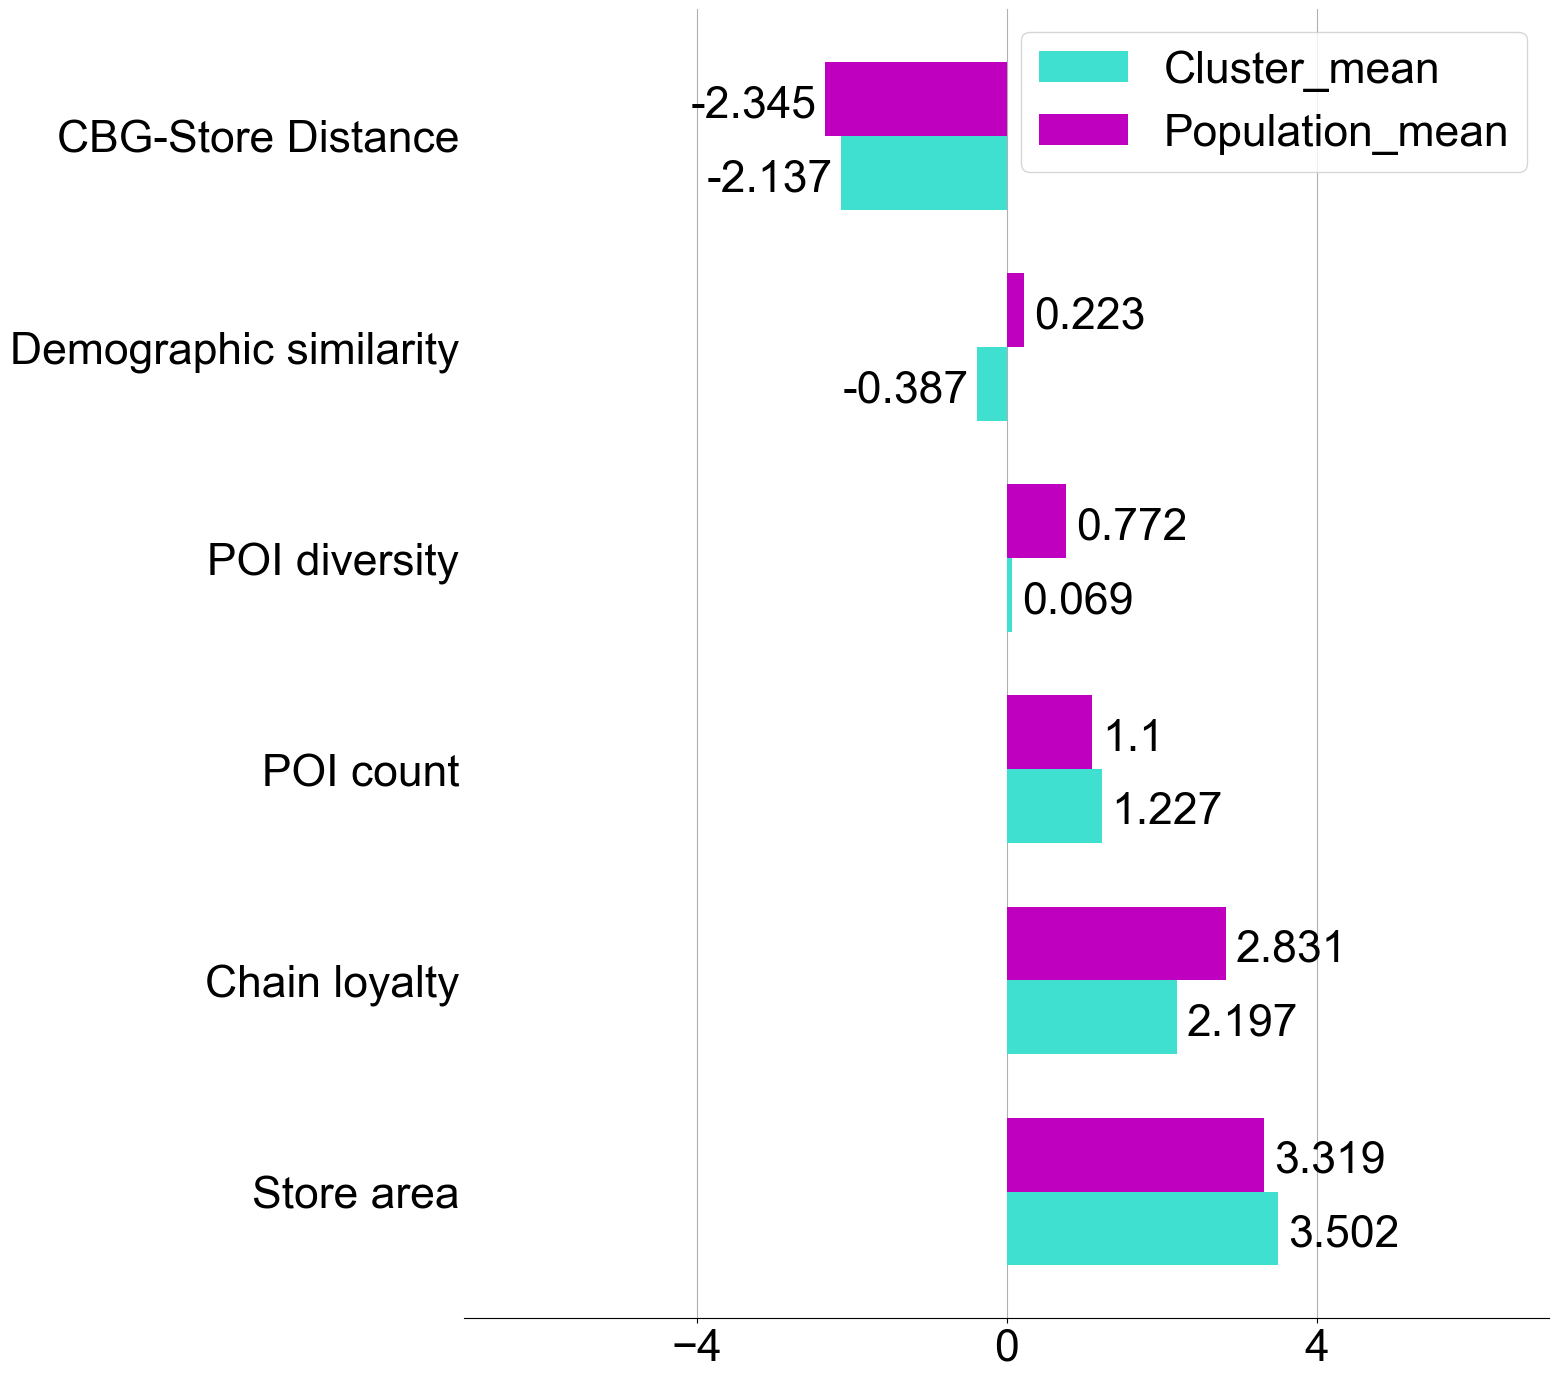

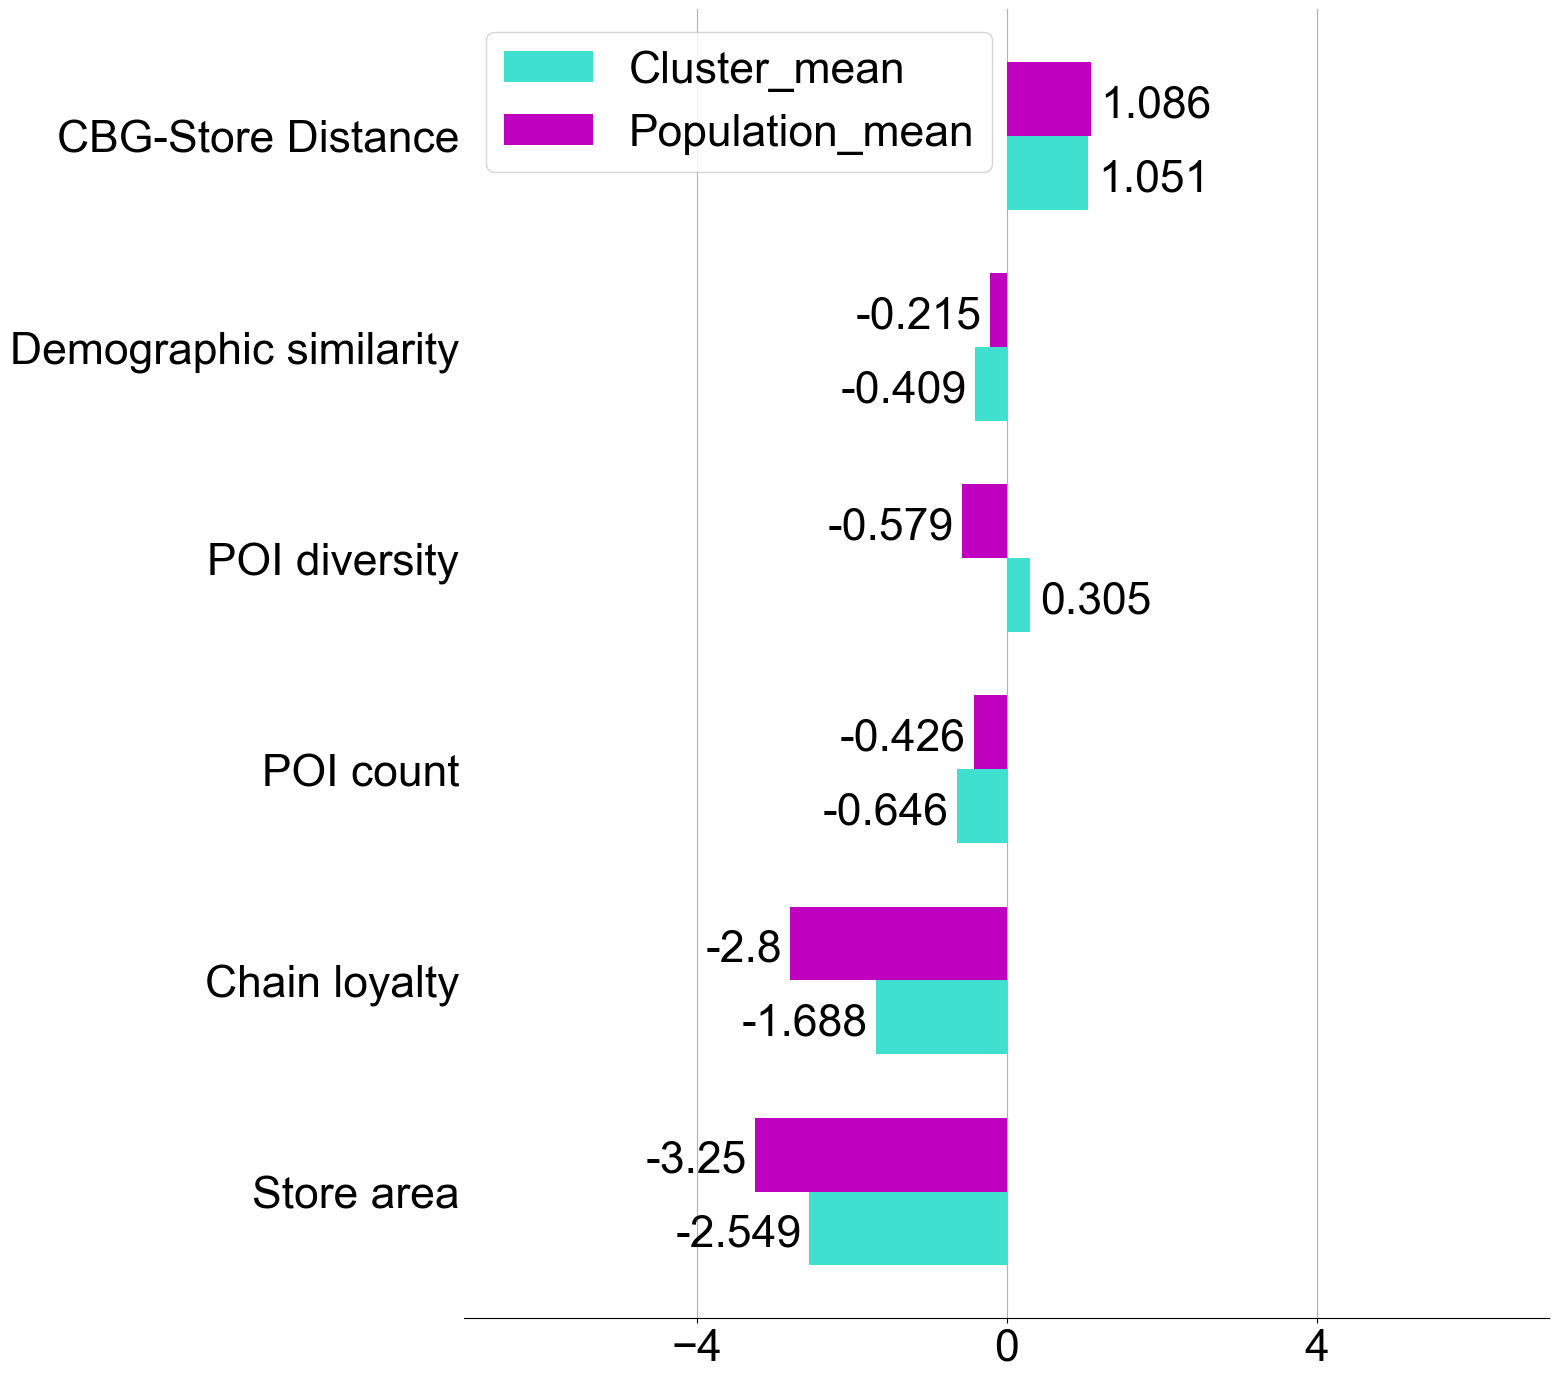

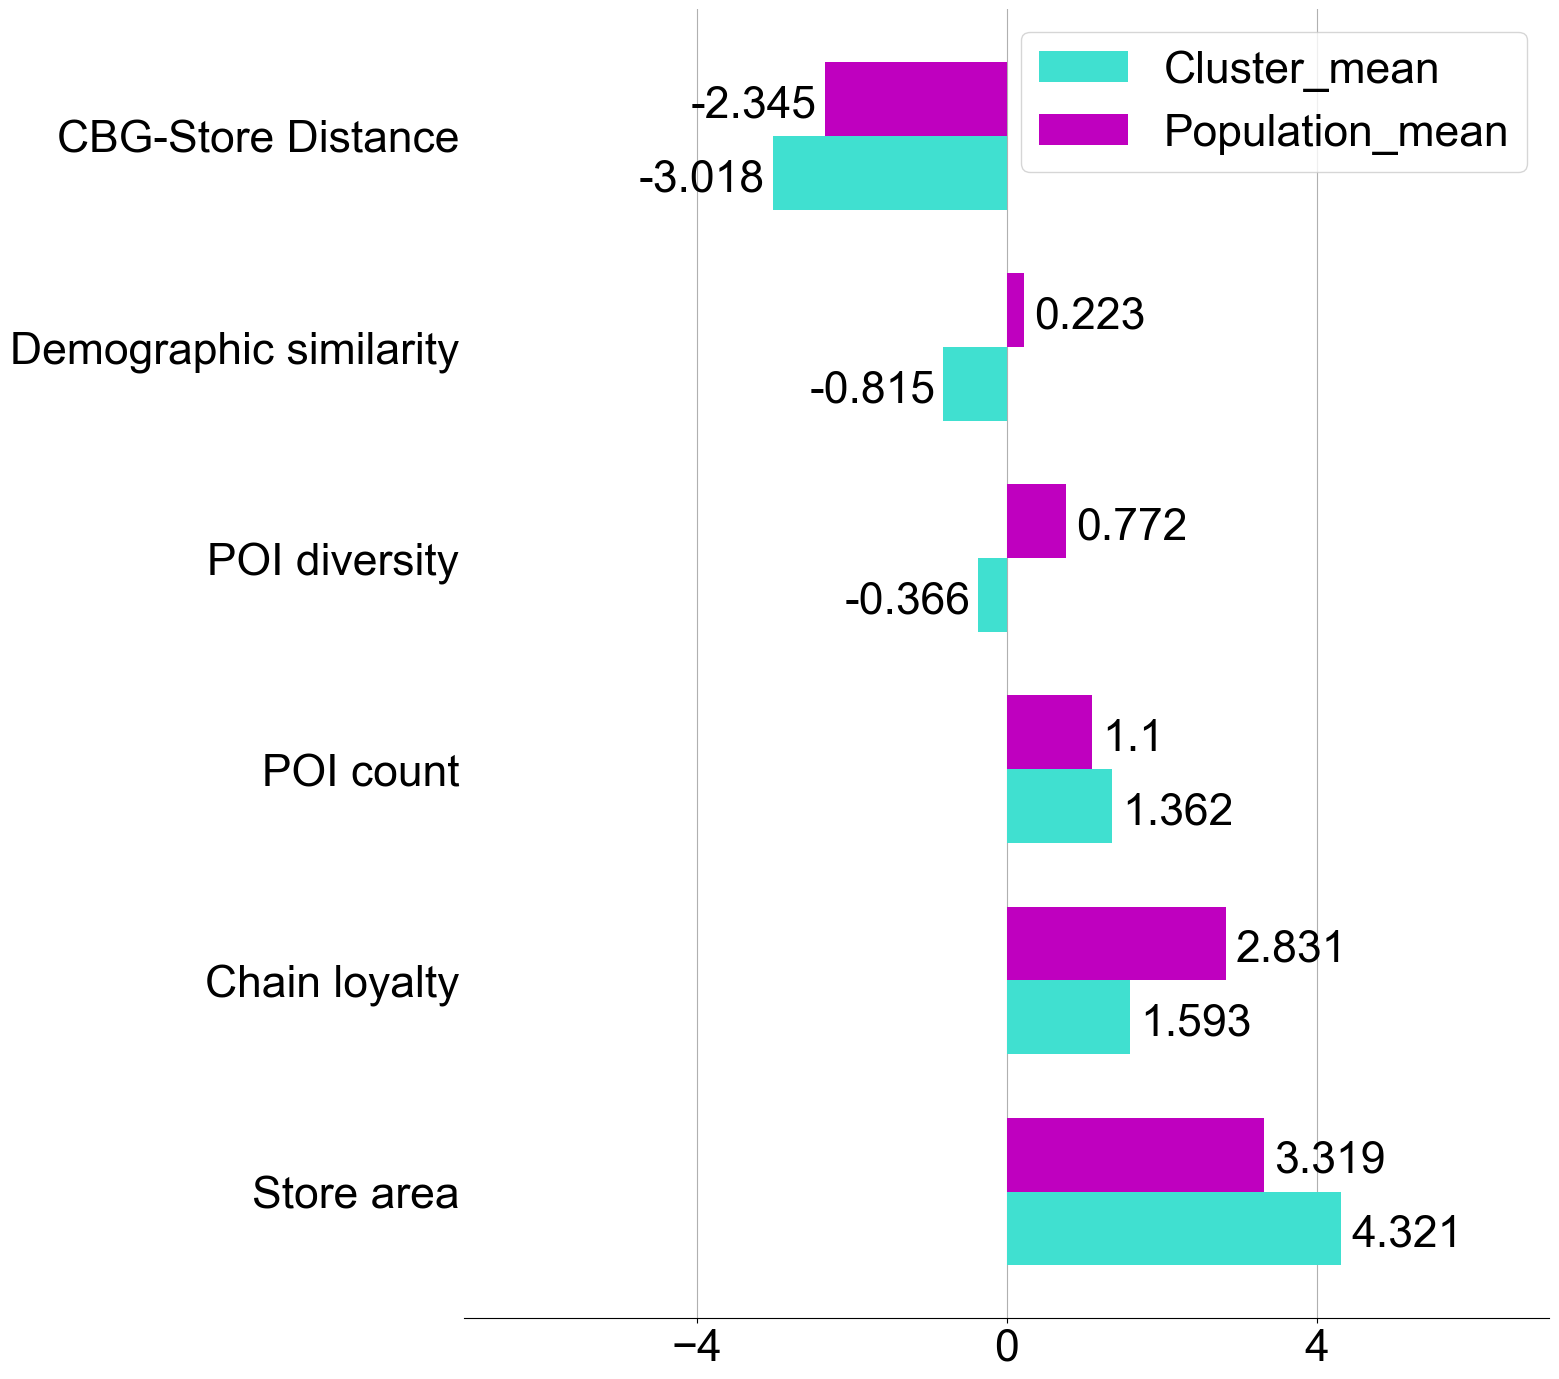

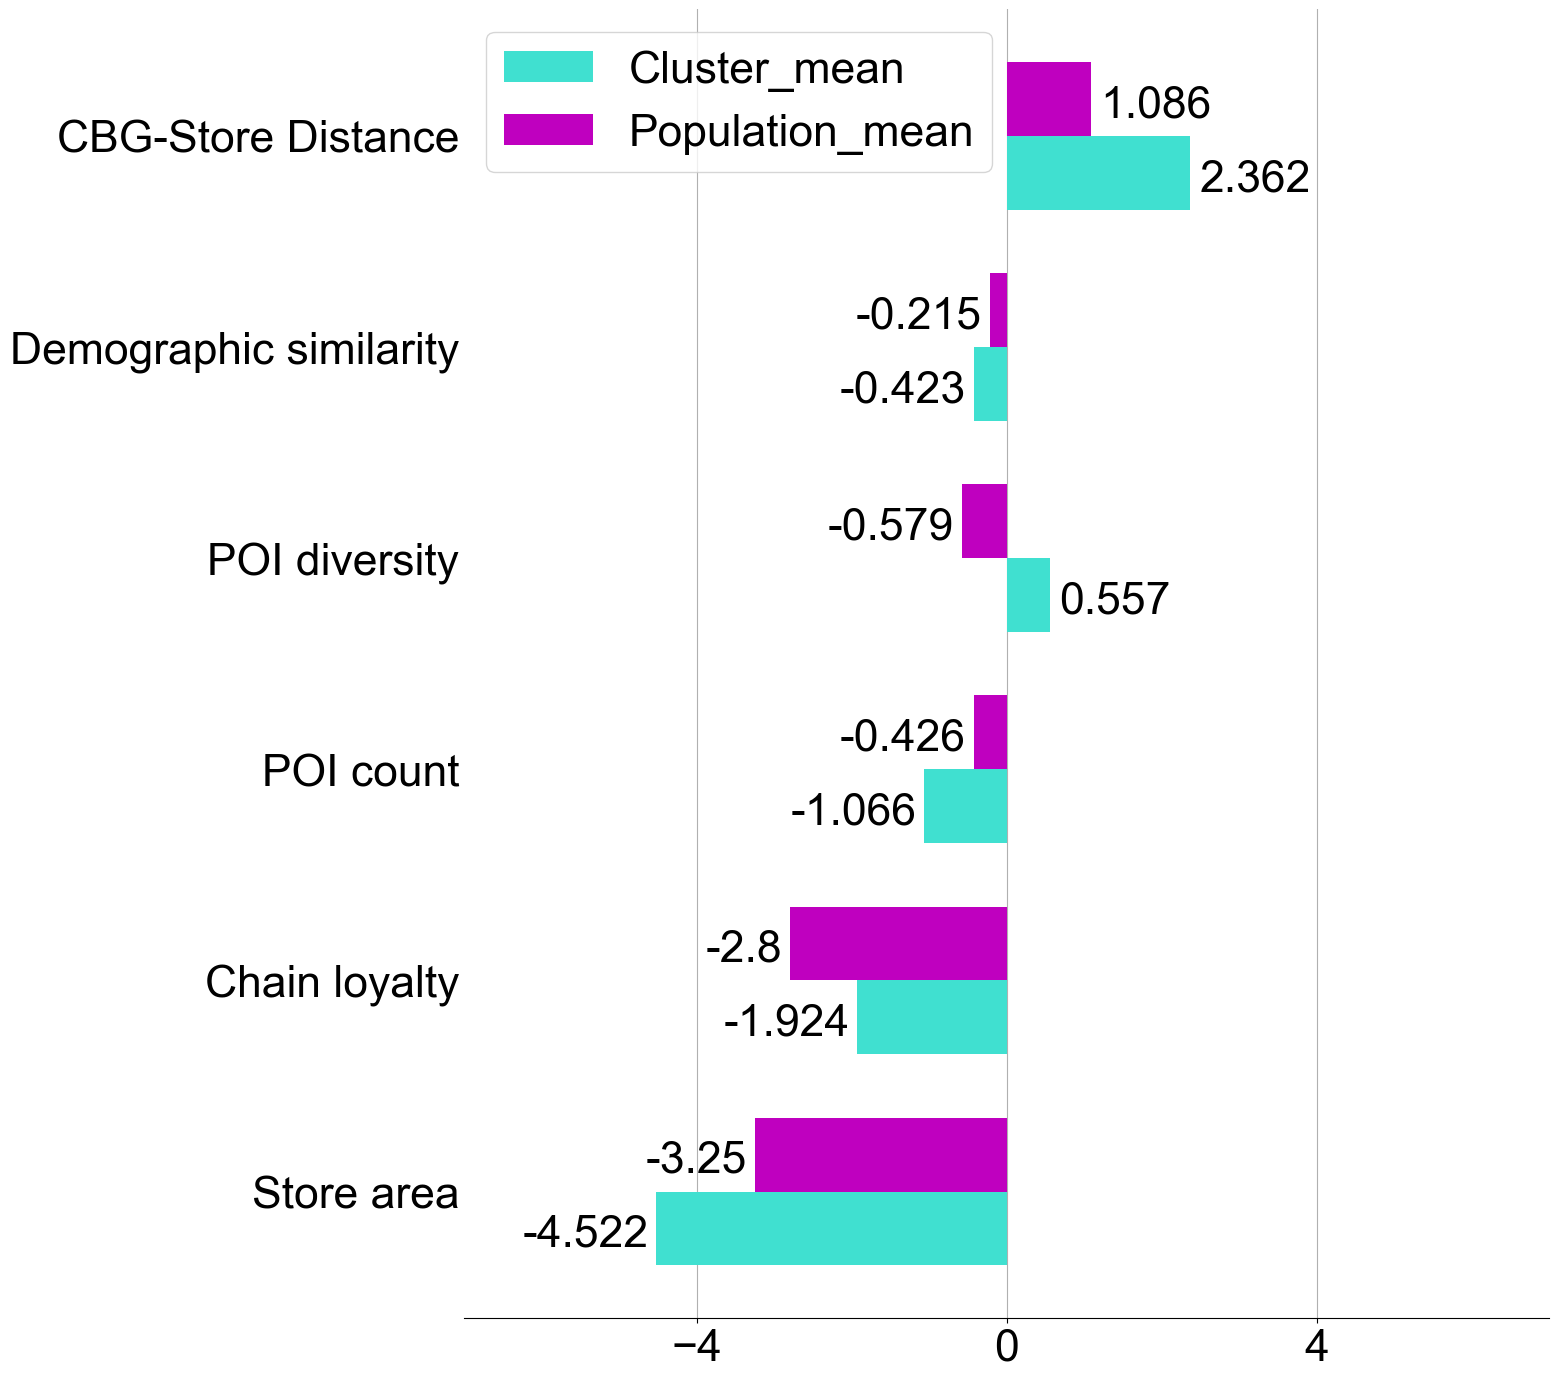

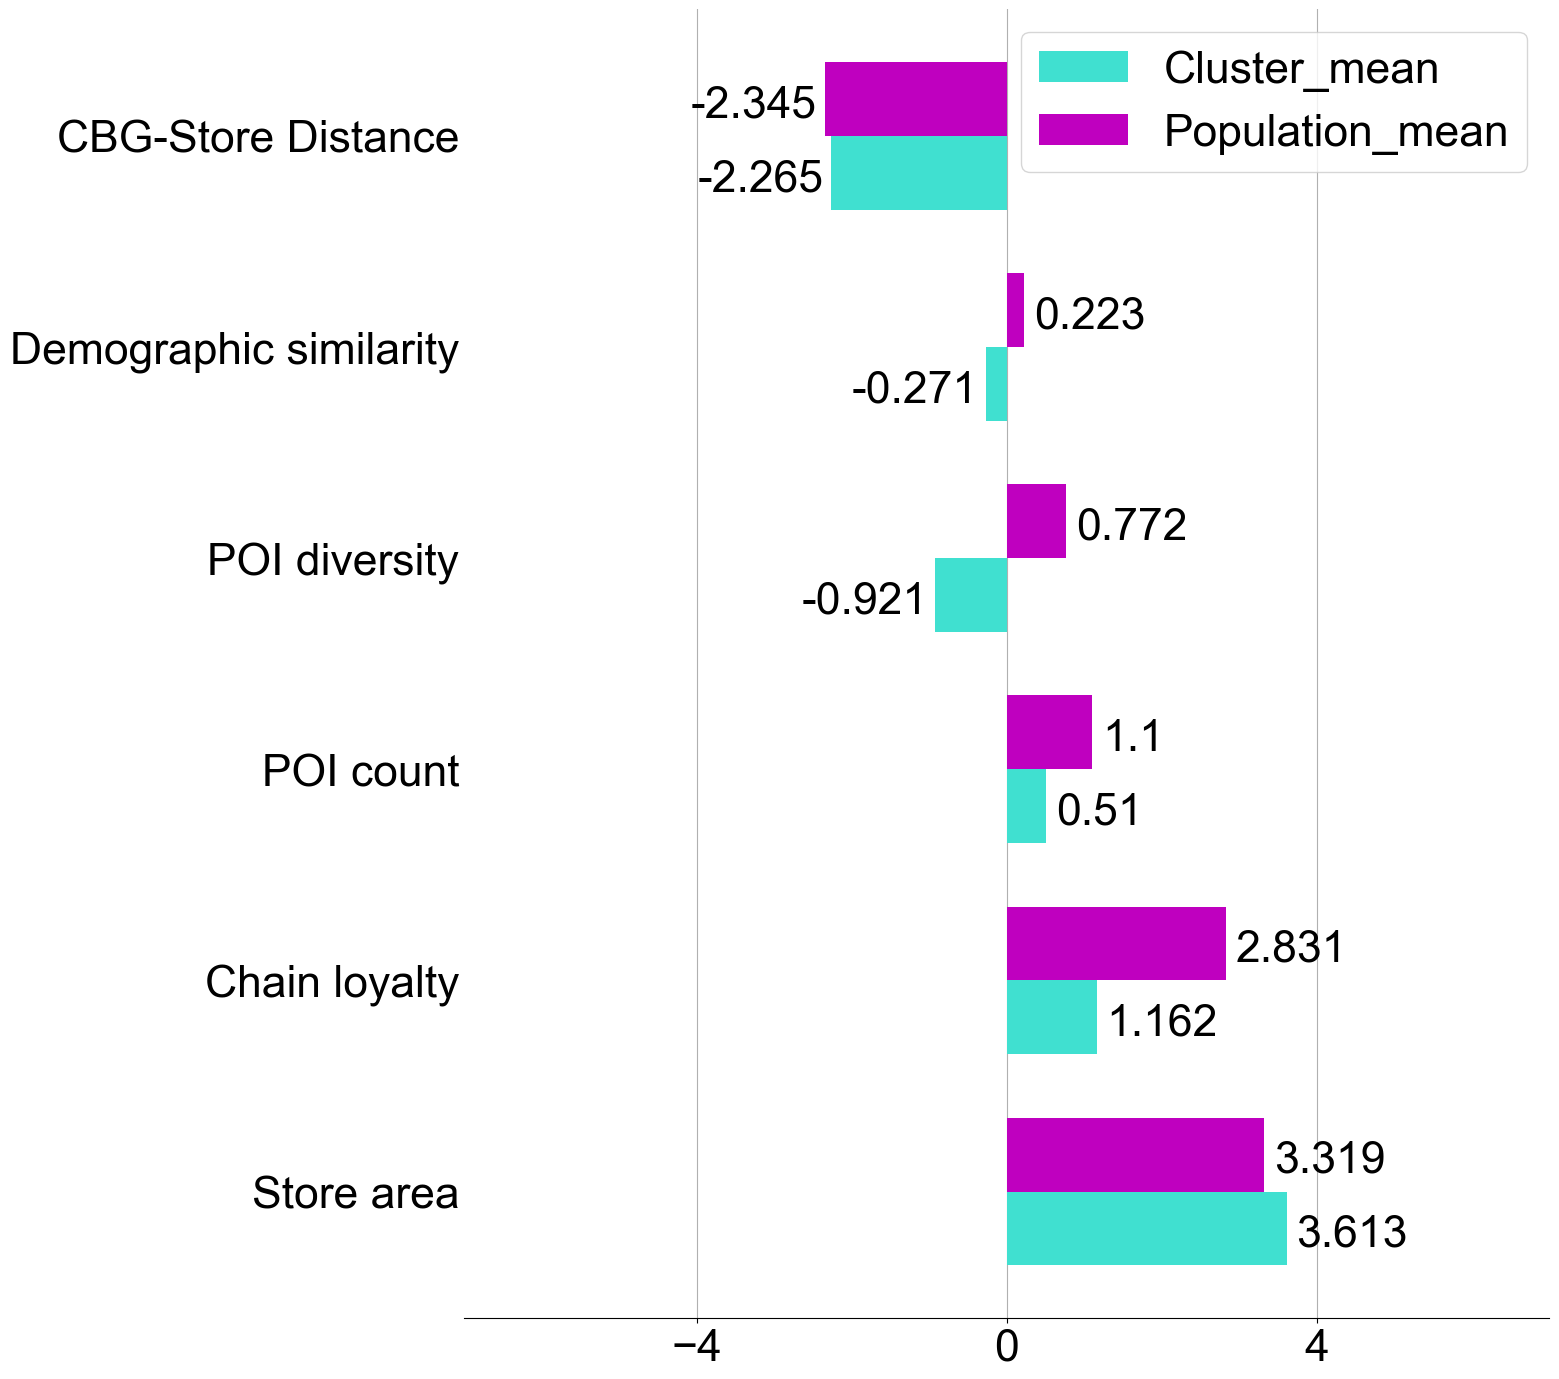

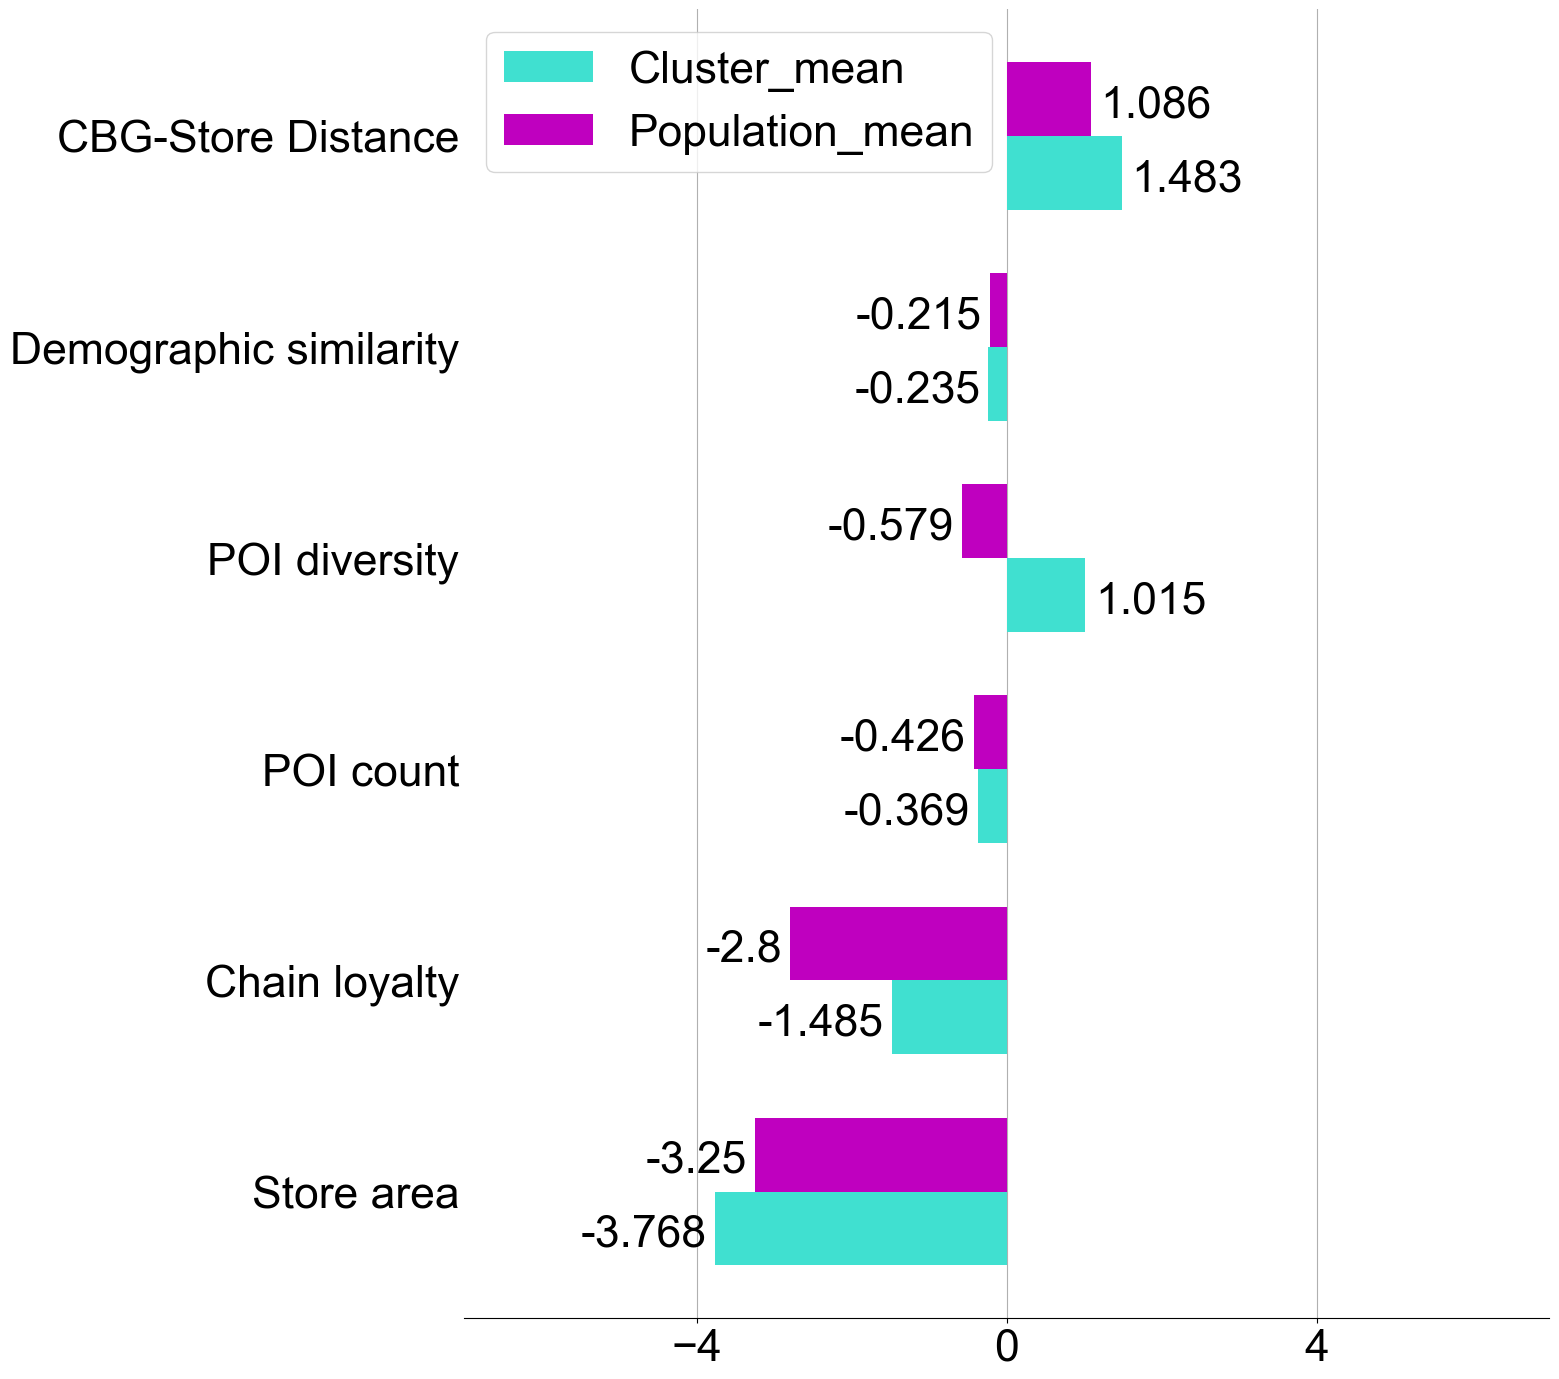

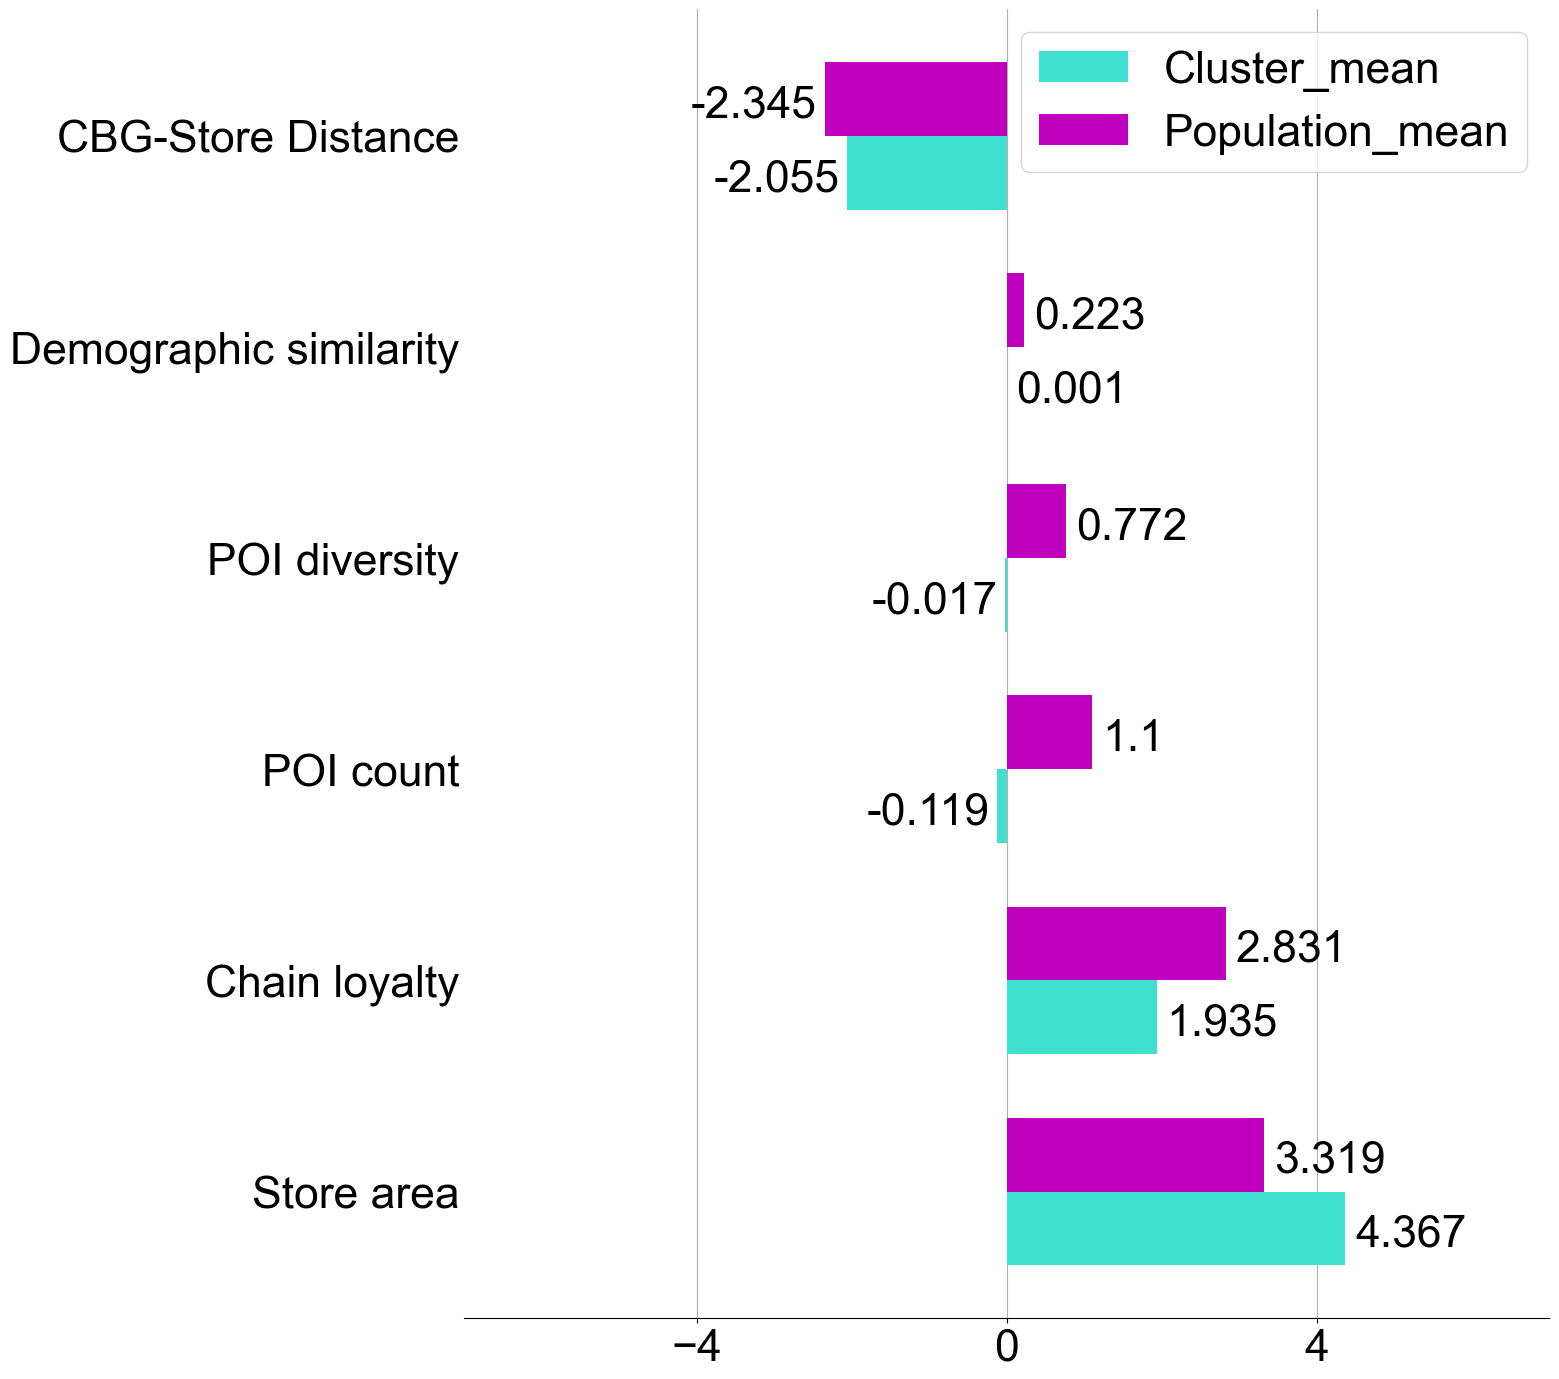

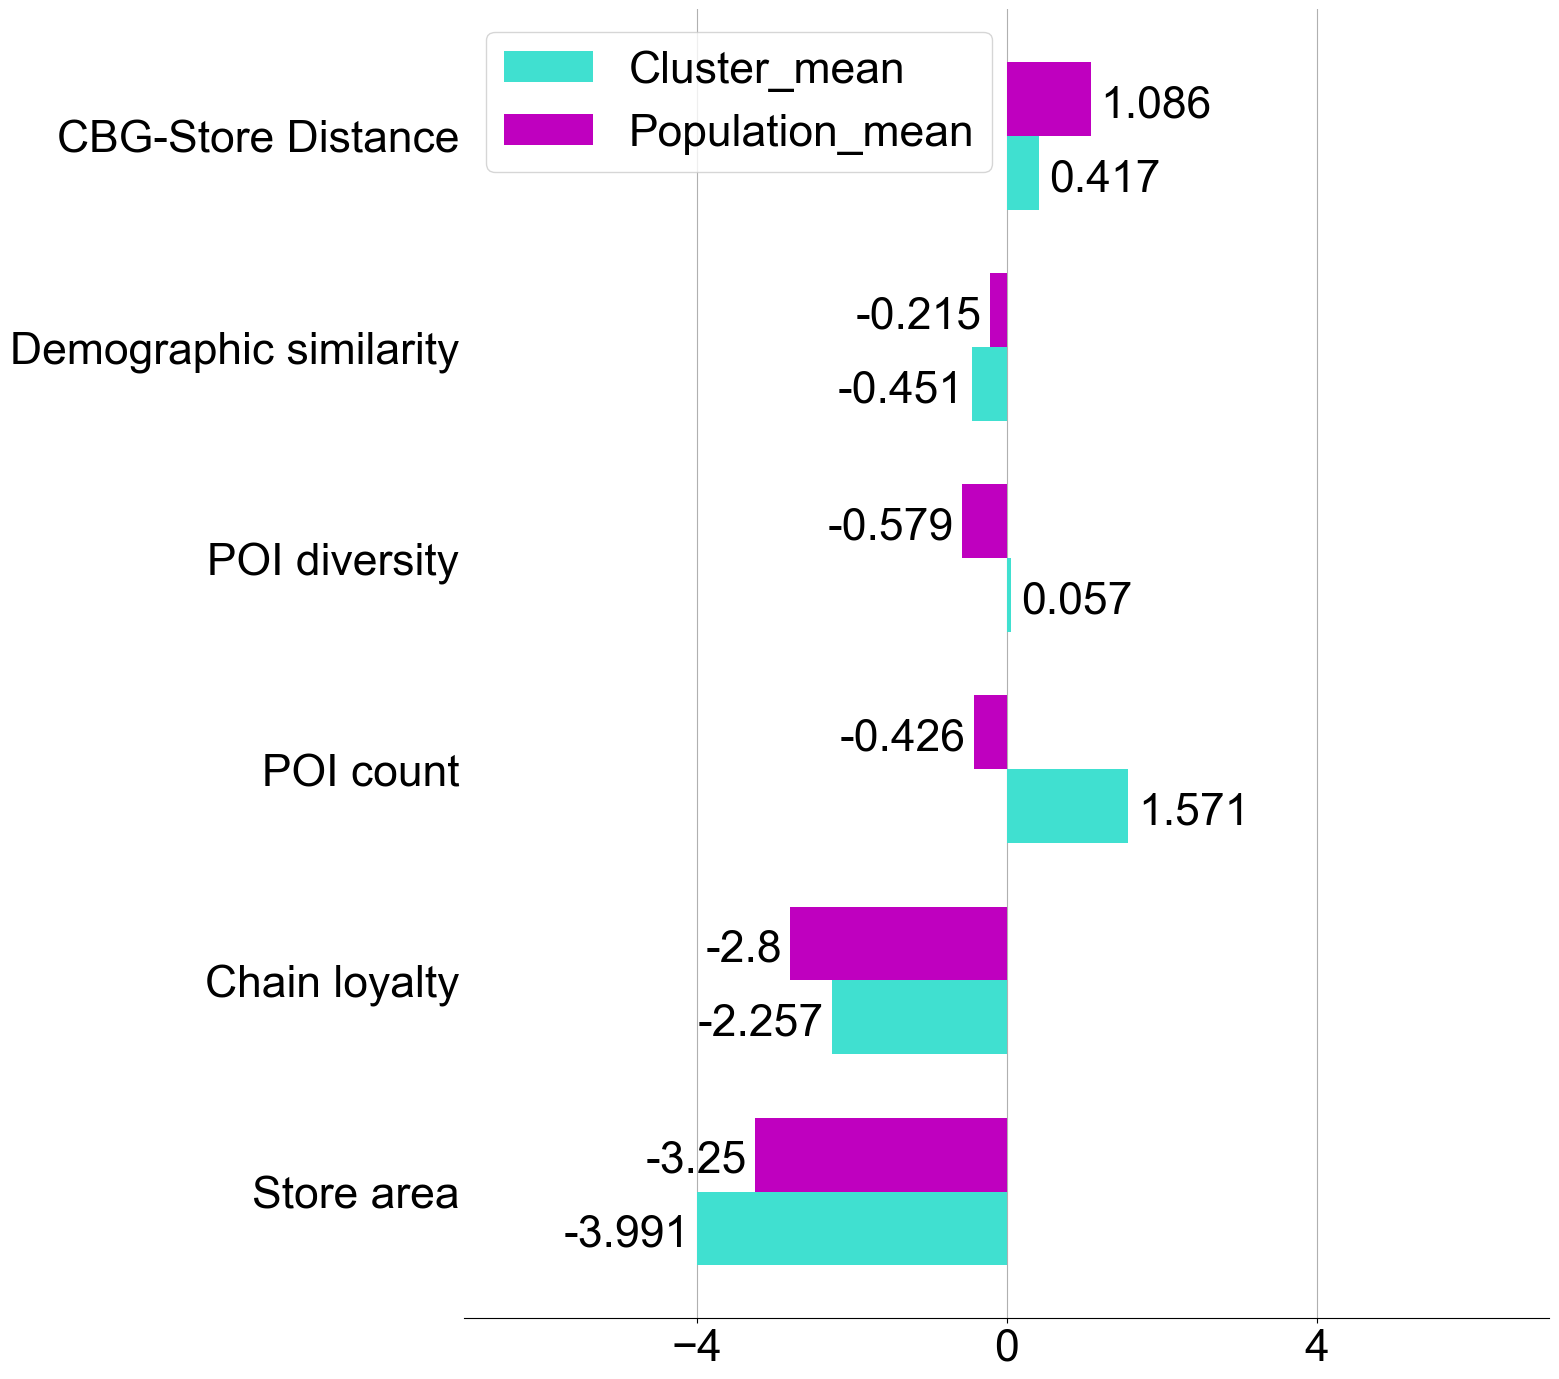

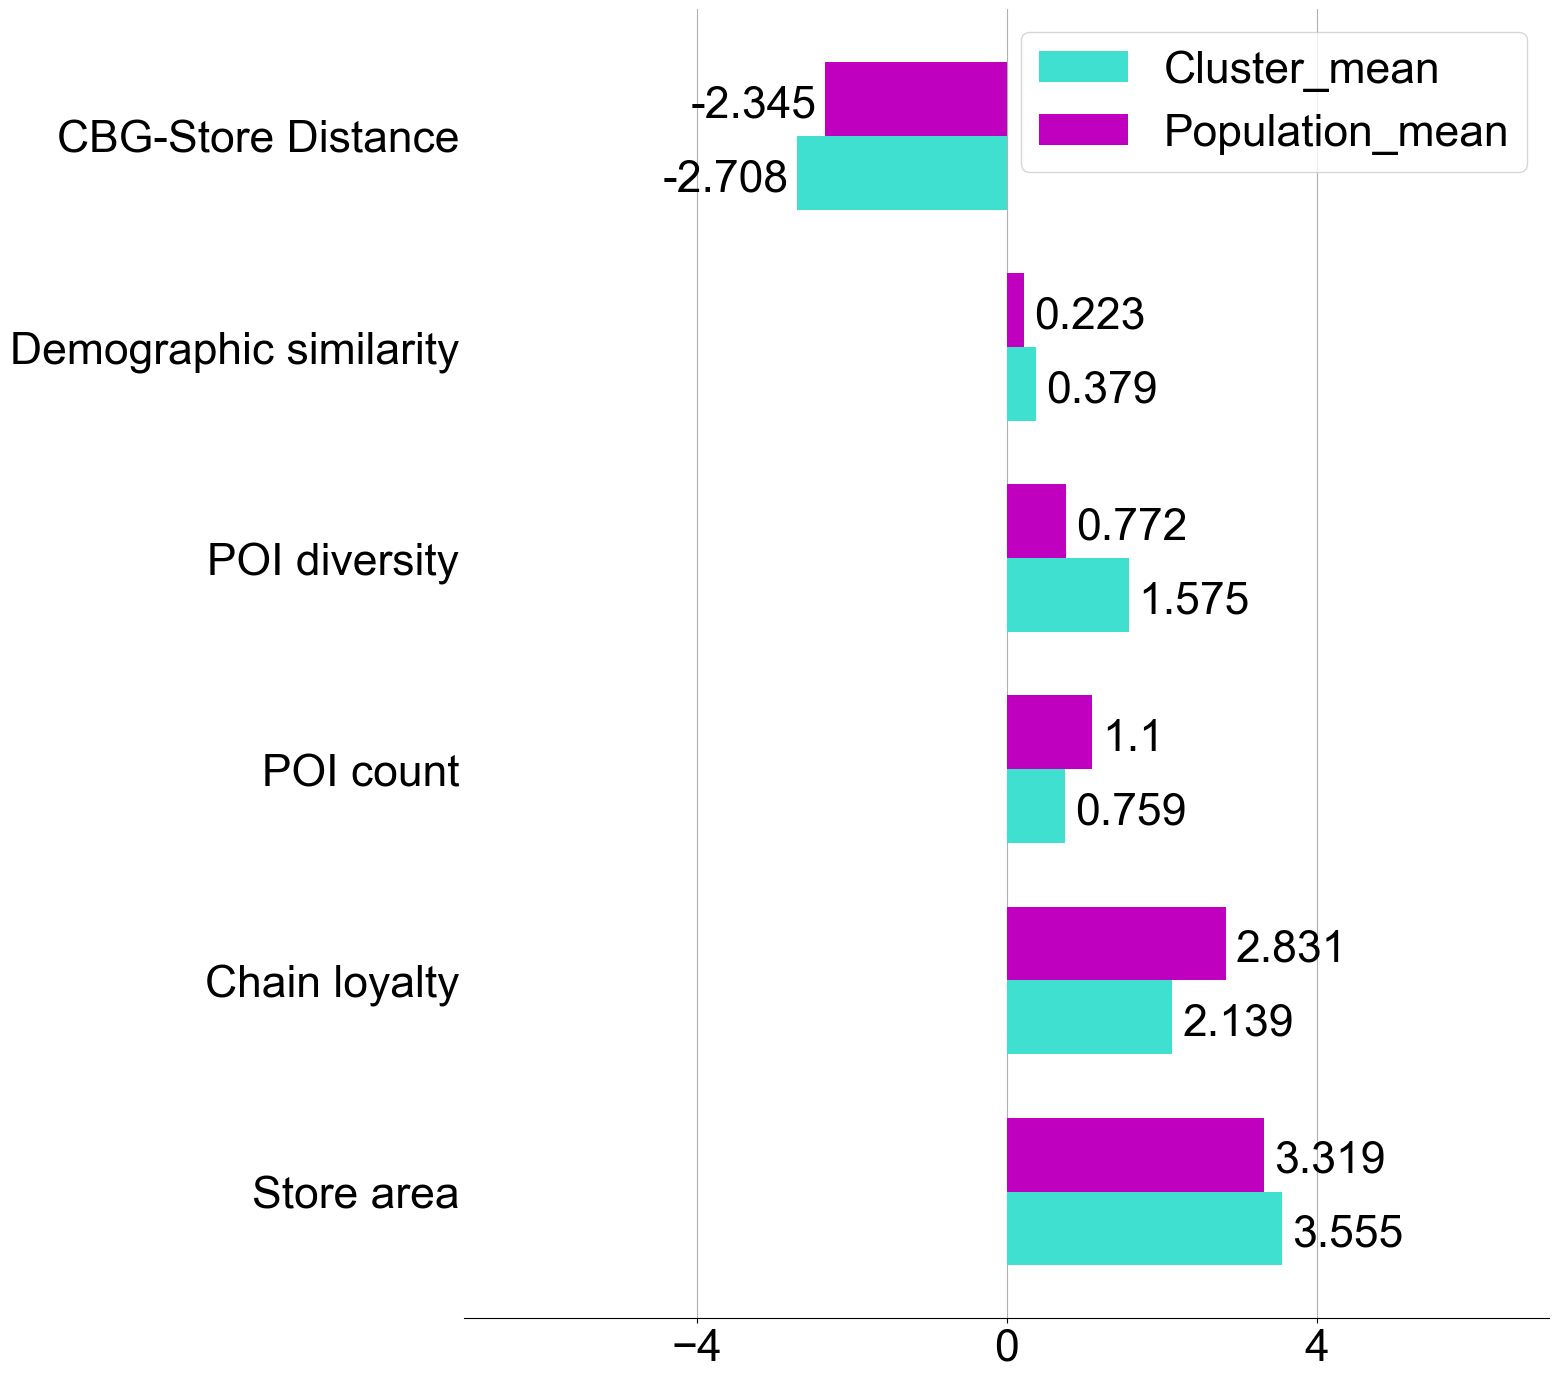

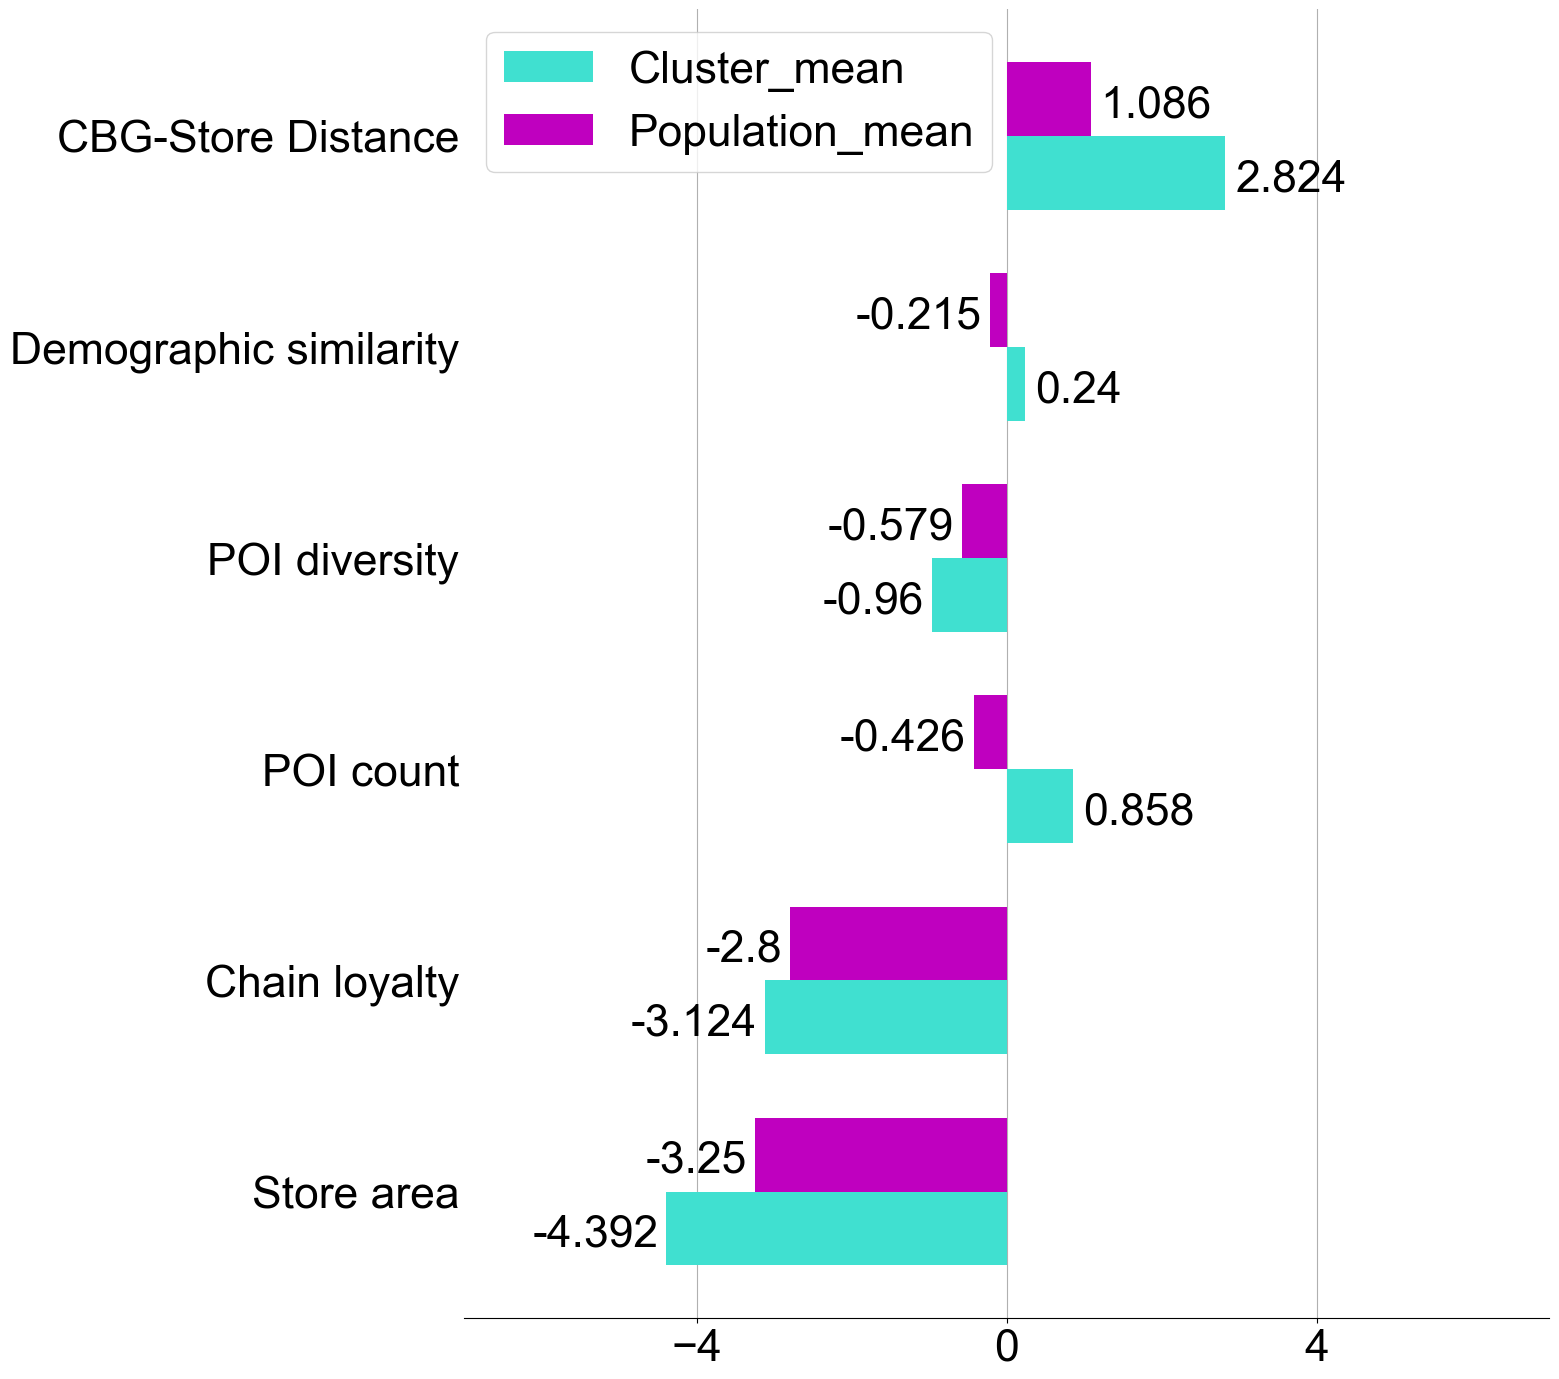

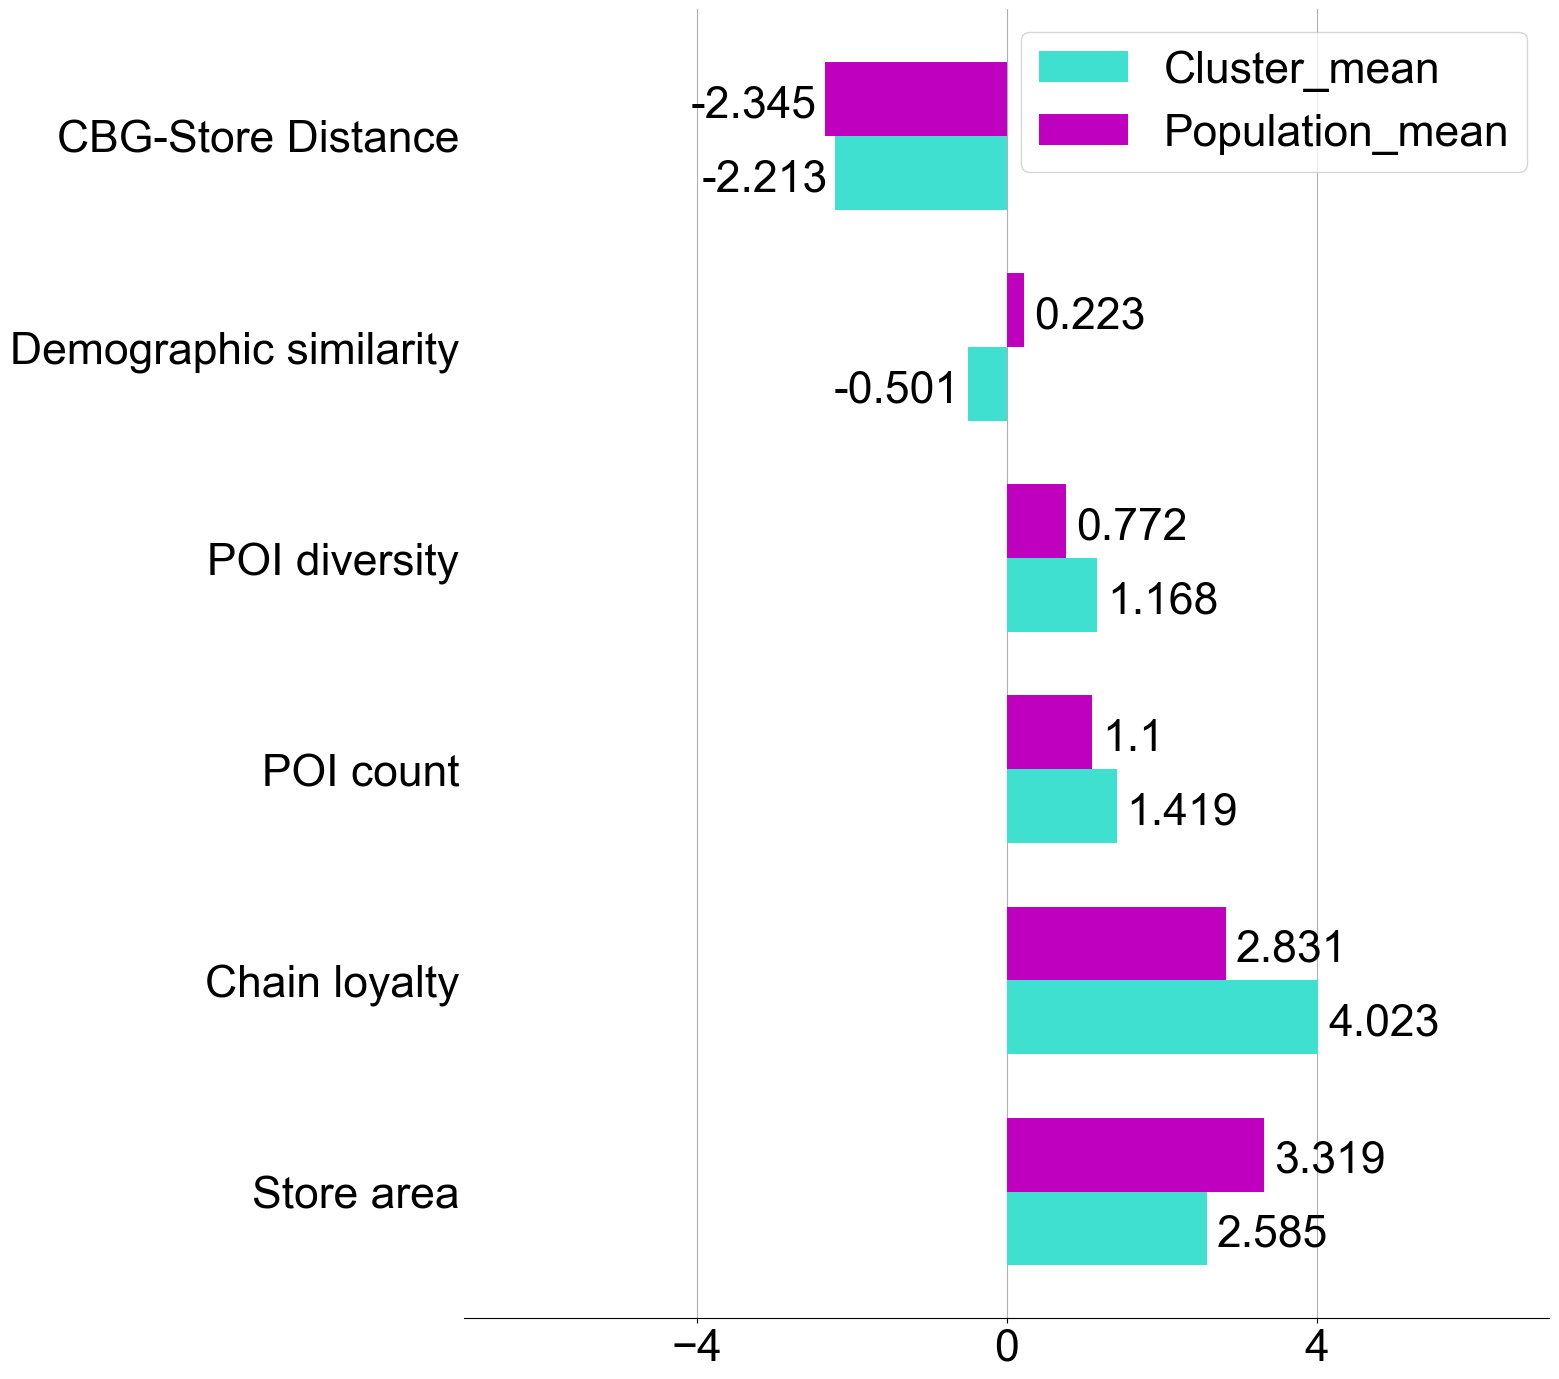

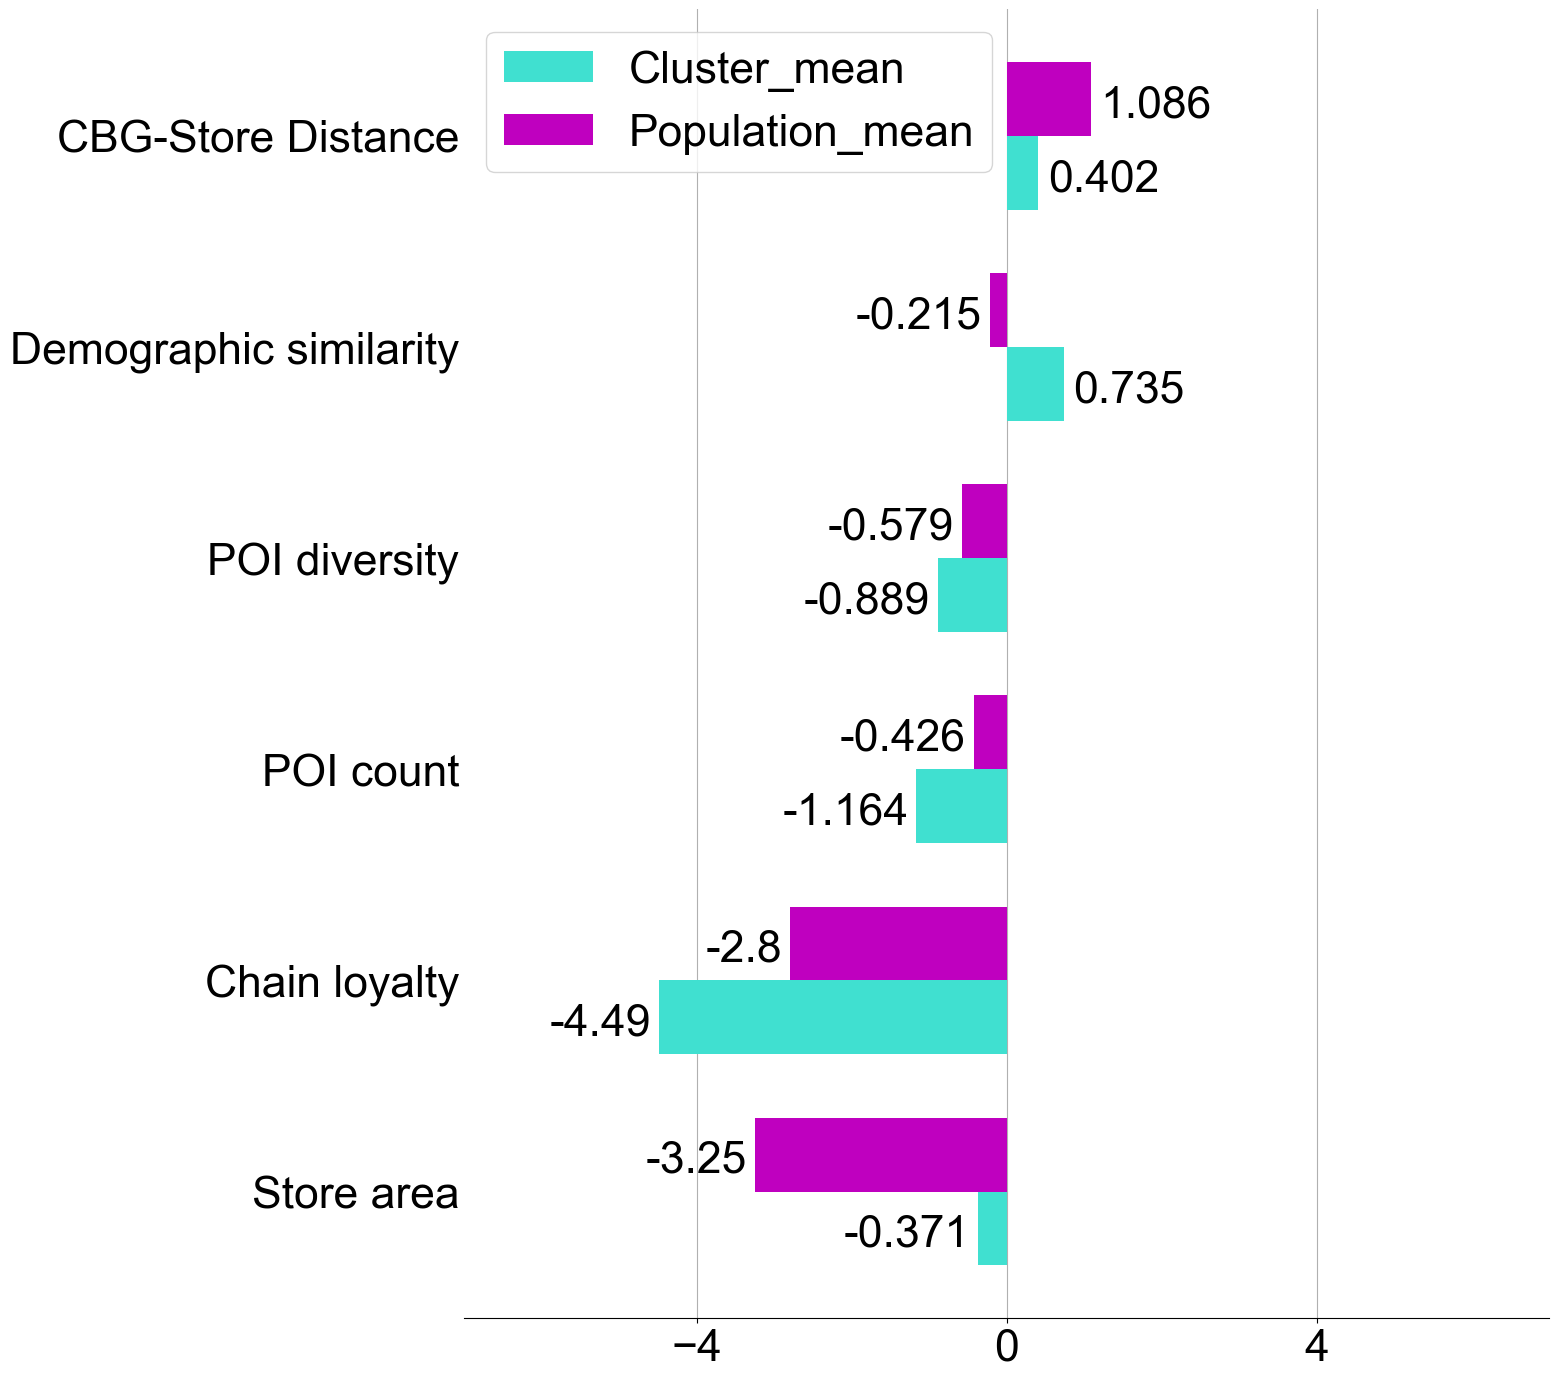

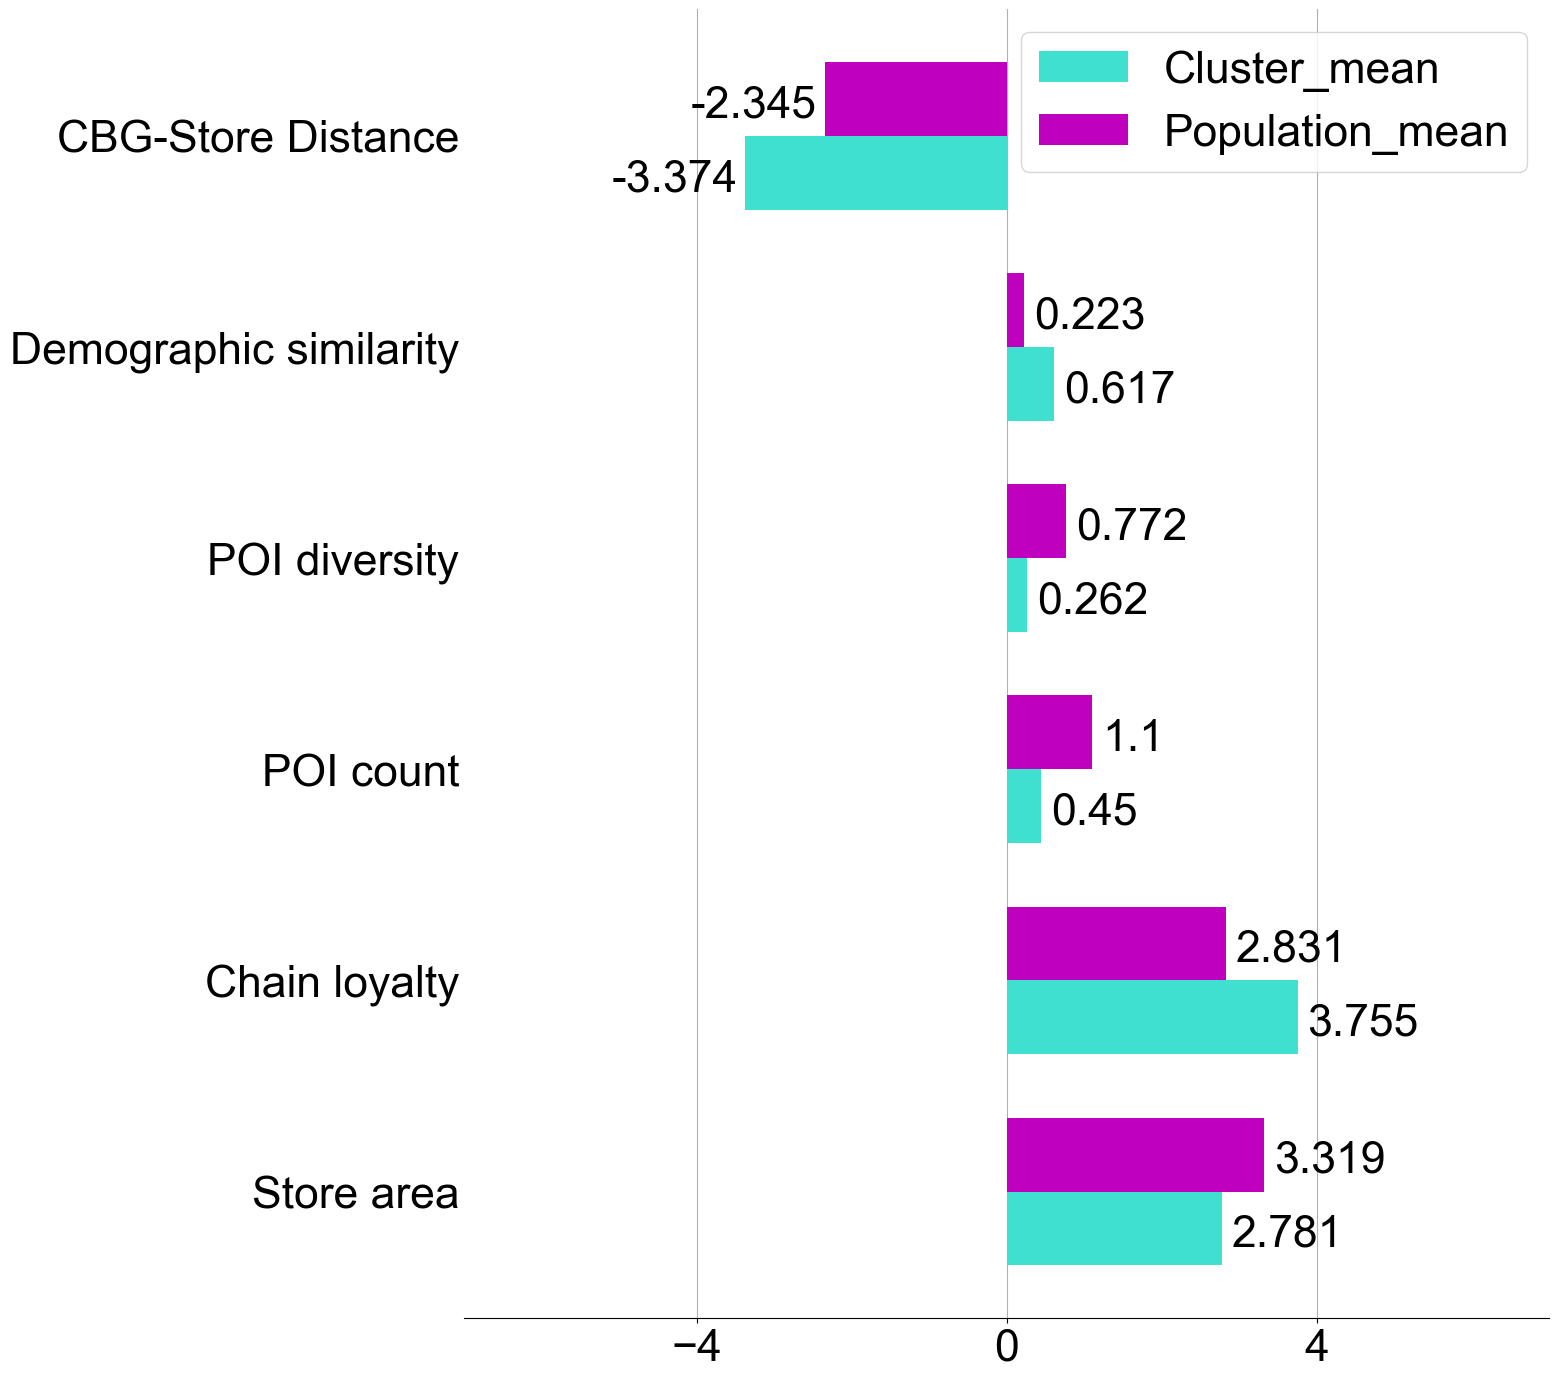

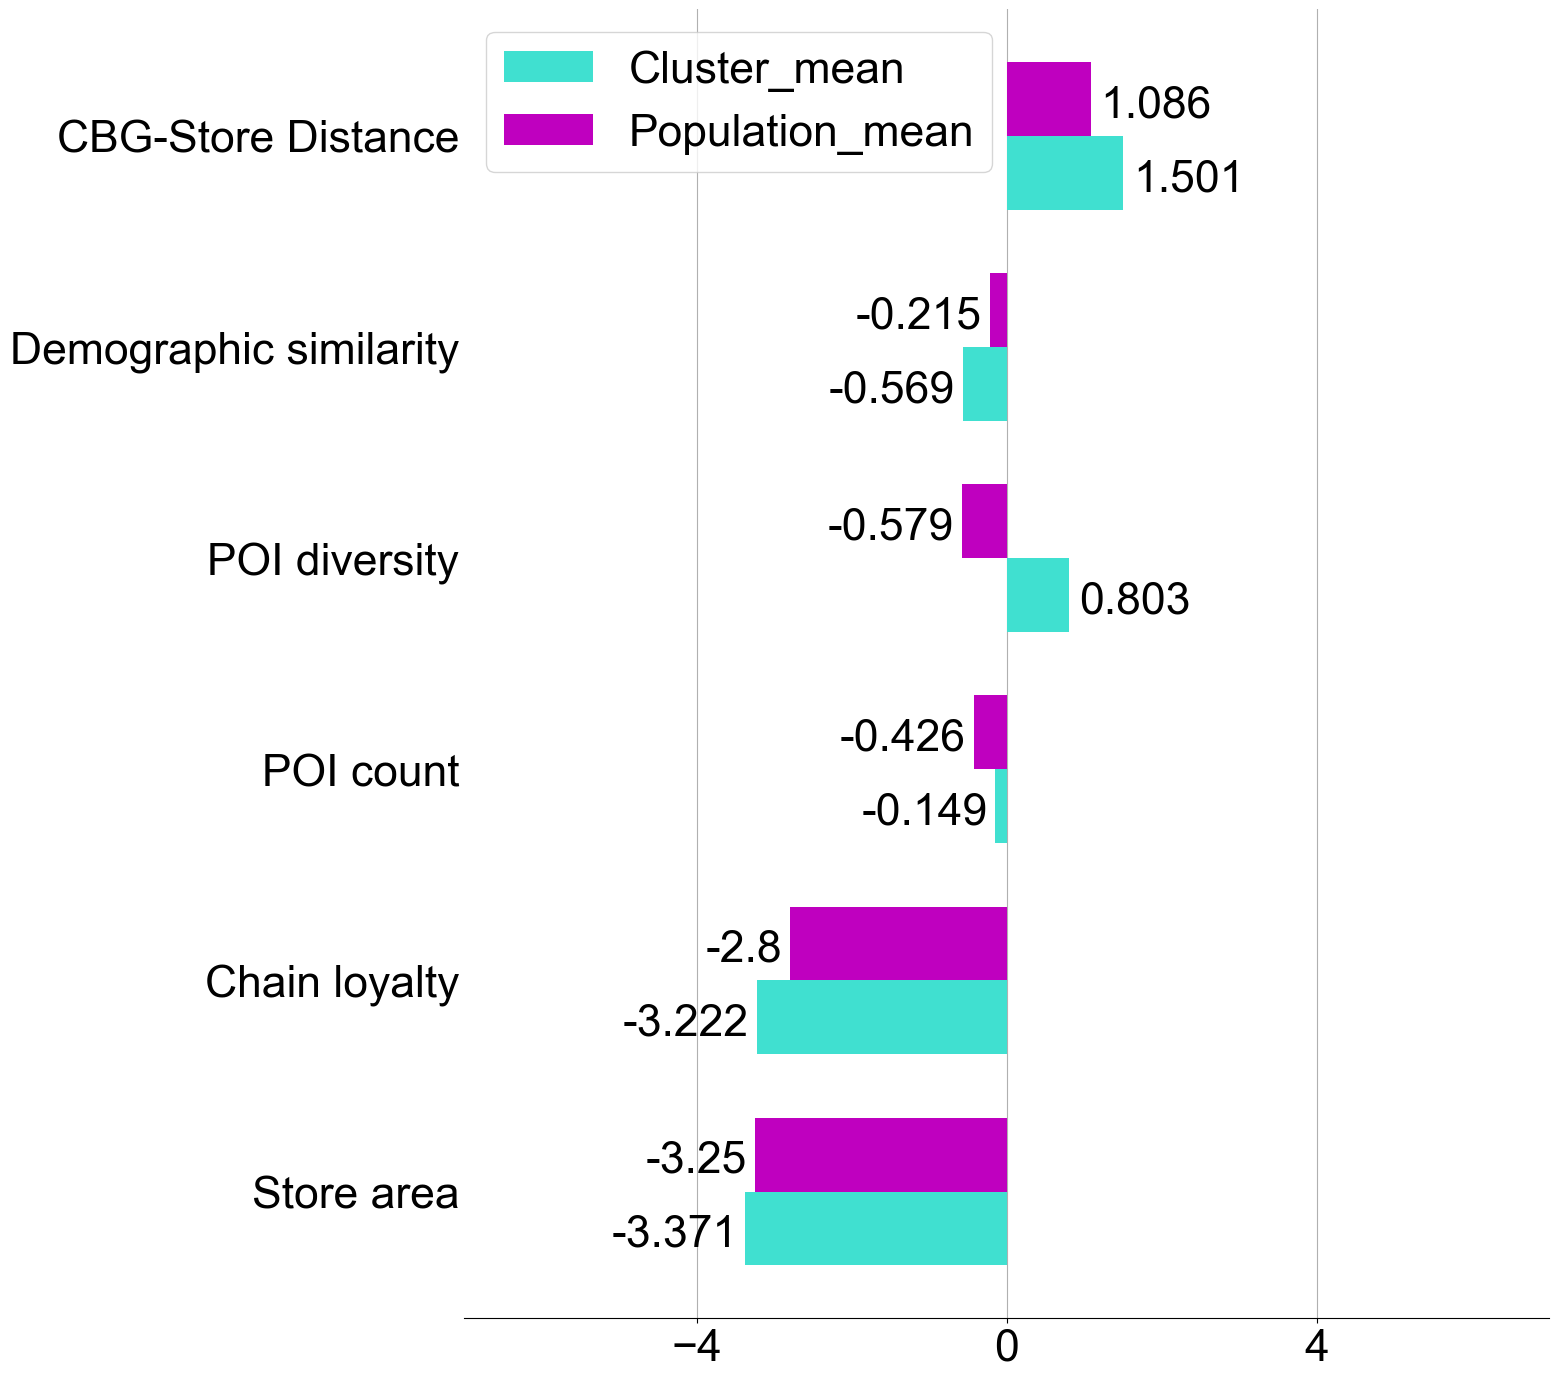

In [27]:
def get_top_ses(var, prop, as_of_year):

    if as_of_year == 2020:
        d_here = params_as_of_2020.copy()
    
    if as_of_year == 2021:
        d_here = params_as_of_2021.copy()


    d_here = d_here[d_here['cbg'].isin(d_here.nlargest(int(len(d_here)*prop), var)['cbg'].tolist())]
    threshold_here = round(min(d_here[var]),3)
    d_here = d_here[[i+'_delta' for i in variables]].mean().reset_index().rename(
        columns = {'index': 'Variable', 0: 'Cluster_mean'})
    
    d_here['Variable'] = d_here['Variable'].apply(lambda x: x.replace('_delta',''))
    d_here['Feature'] = d_here['Variable'].apply(lambda x: vars_definition[x])

    d_here['Population_mean'] = d_here['Variable'].apply(lambda x: delta_means[str(as_of_year)][x])
    
    bplot = d_here[['Feature', 'Cluster_mean', 'Population_mean']].plot.barh(rot=0, x = 'Feature', figsize=(14,17),
                                                         color={"Cluster_mean": "turquoise", "Population_mean": "m"},
                                                         align='center', width=0.7)
    title_here = var + " (Top " + "{0:.0%}".format(prop) + ', at least ' + str(threshold_here) +')'


    if as_of_year == 2020:
        axis_upper = 7
        axis_lower = -7
        loc = plticker.MultipleLocator(base=4)
        bplot.xaxis.set_major_locator(loc)
    else:
        axis_upper = 7
        axis_lower = -7
        loc = plticker.MultipleLocator(base=4)
        bplot.xaxis.set_major_locator(loc)
        
    plt.xlim(axis_lower, axis_upper)
    
    for indx, p in enumerate(bplot.patches):
        if p.get_width() >= 0:
            if as_of_year == 2020:
                bplot.annotate(round(p.get_width(), 3),
                               (p.get_width()+0.02, p.get_y()+p.get_height()/4),
                               ha='left', va='center',
                               xytext=(6, 9),
                               textcoords='offset points', size = 32)
            else:
                bplot.annotate(round(p.get_width(), 3),
                               (p.get_width()+0.02, p.get_y()+p.get_height()/4),
                               ha='left', va='center',
                               xytext=(6, 9),
                               textcoords='offset points', size = 32)
        else:
            if as_of_year == 2020:
                bplot.annotate(round(p.get_width(), 3),
                               (p.get_width()-0.1, p.get_y()+p.get_height()/4),
                               ha='right', va='center',
                               xytext=(0, 9),
                               textcoords='offset points', size = 32)
            else:
                bplot.annotate(round(p.get_width(), 3),
                               (p.get_width()-0.1, p.get_y()+p.get_height()/4),
                               ha='right', va='center',
                               xytext=(0, 9),
                               textcoords='offset points', size = 32)
            
    plt.xticks(rotation = 0, size = 32)
    plt.yticks(size = 32)

    plt.grid(axis = 'x')
    bplot.spines['top'].set_visible(False)
    bplot.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    bplot.spines['left'].set_visible(False)
    bplot.set_axisbelow(True)
    bplot.yaxis.set_tick_params(length=0)
    plt.ylabel(None)
    
    plt.legend(fontsize = 32)
    
    
    plt.savefig(str(as_of_year) +'/' + 
        var + ' (Top_delta_' + str(as_of_year)  + ').jpg', dpi=300, bbox_inches='tight')
    
    plt.show()


for s in ses:
    get_top_ses(s, 0.05, 2020)
    get_top_ses(s, 0.05, 2021)

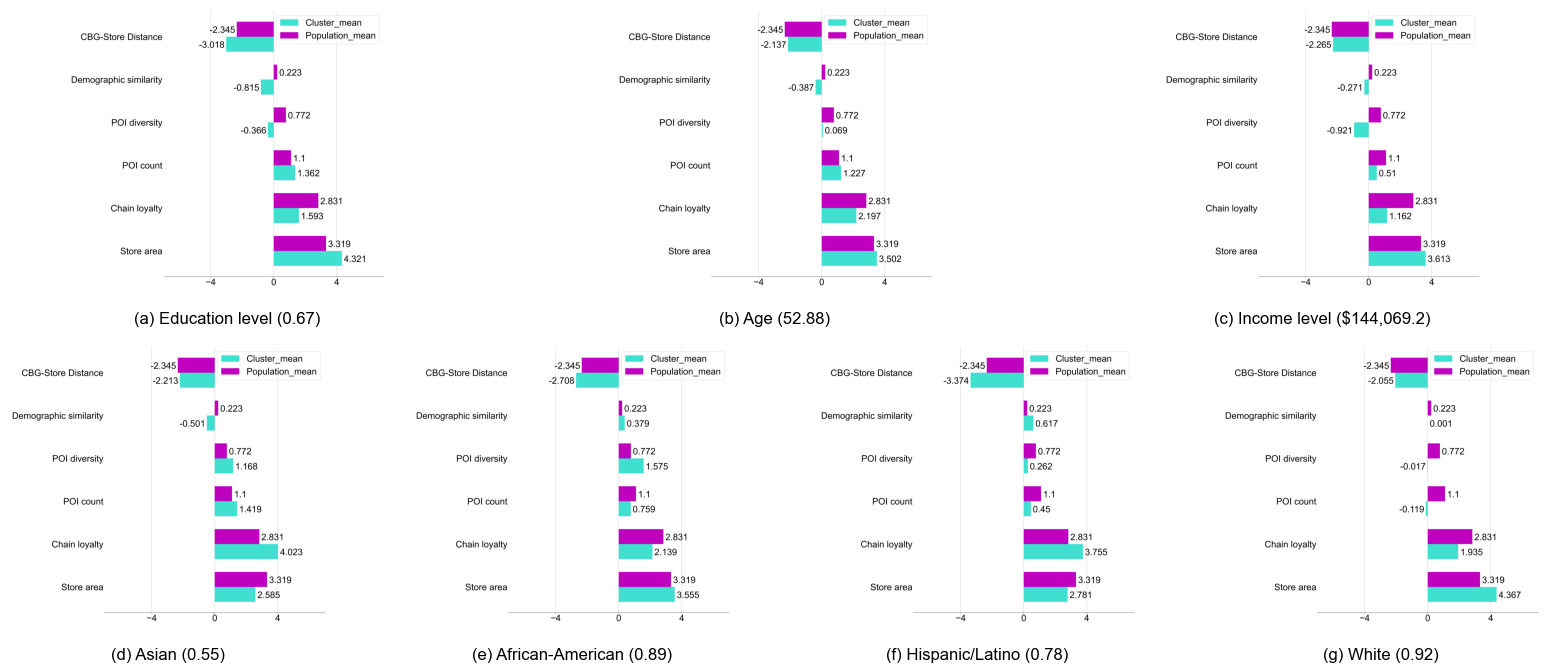

In [28]:
Image1 = Image.open(
    '2020/bachelor_degree_25E (Top_delta_2020).jpg')
Image2 = Image.open(
    '2020/med_ageE (Top_delta_2020).jpg')
Image3 = Image.open(
    '2020/med_hh_incomeE (Top_delta_2020).jpg')
Image4 = Image.open(
    '2020/asianE (Top_delta_2020).jpg')
Image5 = Image.open(
    '2020/blackE (Top_delta_2020).jpg')
Image6 = Image.open(
    '2020/hispanicE (Top_delta_2020).jpg')
Image7 = Image.open(
    '2020/whiteE (Top_delta_2020).jpg')
fig = plt.figure(figsize=(20, 8))

# Adds a subplot at the 1st position
fig.add_subplot(2, 3, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("(a) Education level ("+str(census_top_stats['bachelor_degree_25E'])+')', y=-0.15)
  
# Adds a subplot at the 2nd position
fig.add_subplot(2, 3, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("(b) Age ("+str(census_top_stats['med_ageE'])+')', y=-0.15)
  
# Adds a subplot at the 3rd position
fig.add_subplot(2, 3, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("(c) Income level ($"+str('{:,}'.format(census_top_stats['med_hh_incomeE']))+')', y=-0.15)
  
# Adds a subplot at the 4th position
fig.add_subplot(2, 4, 5)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("(d) Asian ("+str(census_top_stats['asianE'])+')', y=-0.15)

# # Adds a subplot at the 5th position
fig.add_subplot(2, 4, 6)
  
# showing image
plt.imshow(Image5)
plt.axis('off')
plt.title("(e) African-American ("+str(census_top_stats['blackE'])+')', y=-0.15)

# Adds a subplot at the 6th position
fig.add_subplot(2, 4, 7)
  
# showing image
plt.imshow(Image6)
plt.axis('off')
plt.title("(f) Hispanic/Latino ("+str(census_top_stats['hispanicE'])+')', y=-0.15)

# Adds a subplot at the 7th position
fig.add_subplot(2, 4, 8)
  
# showing image
plt.imshow(Image7)
plt.axis('off')
plt.title("(g) White ("+str(census_top_stats['whiteE'])+')', y=-0.15)

plt.savefig(
        'top_ses_cluster_param_delta_change_combination_2020.jpg', 
                dpi=300, bbox_inches='tight')

plt.show()

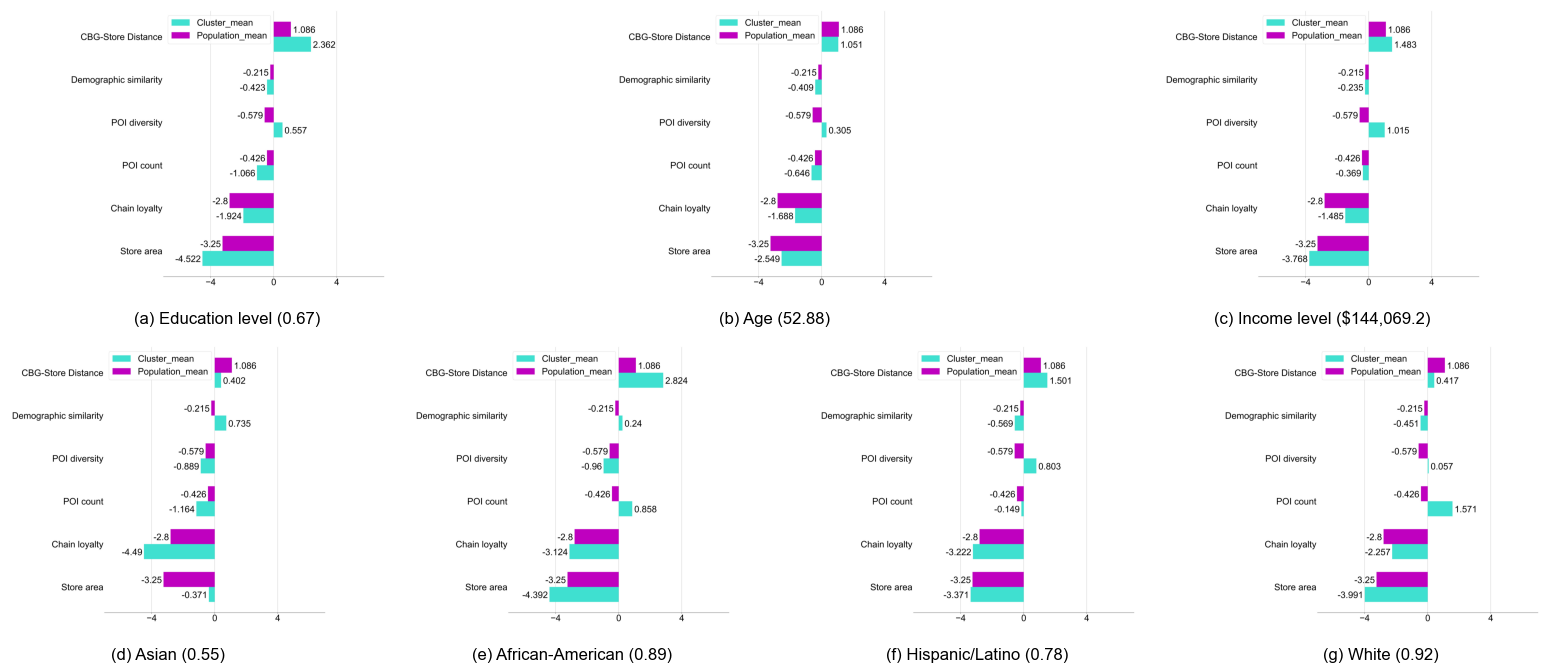

In [29]:
Image1 = Image.open(
    '2021/bachelor_degree_25E (Top_delta_2021).jpg')
Image2 = Image.open(
    '2021/med_ageE (Top_delta_2021).jpg')
Image3 = Image.open(
    '2021/med_hh_incomeE (Top_delta_2021).jpg')
Image4 = Image.open(
    '2021/asianE (Top_delta_2021).jpg')
Image5 = Image.open(
    '2021/blackE (Top_delta_2021).jpg')
Image6 = Image.open(
    '2021/hispanicE (Top_delta_2021).jpg')
Image7 = Image.open(
    '2021/whiteE (Top_delta_2021).jpg')
fig = plt.figure(figsize=(20, 8))

# Adds a subplot at the 1st position
fig.add_subplot(2, 3, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("(a) Education level ("+str(census_top_stats['bachelor_degree_25E'])+')', y=-0.15)
  
# Adds a subplot at the 2nd position
fig.add_subplot(2, 3, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("(b) Age ("+str(census_top_stats['med_ageE'])+')', y=-0.15)
  
# Adds a subplot at the 3rd position
fig.add_subplot(2, 3, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("(c) Income level ($"+str('{:,}'.format(census_top_stats['med_hh_incomeE']))+')', y=-0.15)
  
# Adds a subplot at the 4th position
fig.add_subplot(2, 4, 5)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("(d) Asian ("+str(census_top_stats['asianE'])+')', y=-0.15)

# # Adds a subplot at the 5th position
fig.add_subplot(2, 4, 6)
  
# showing image
plt.imshow(Image5)
plt.axis('off')
plt.title("(e) African-American ("+str(census_top_stats['blackE'])+')', y=-0.15)

# Adds a subplot at the 6th position
fig.add_subplot(2, 4, 7)
  
# showing image
plt.imshow(Image6)
plt.axis('off')
plt.title("(f) Hispanic/Latino ("+str(census_top_stats['hispanicE'])+')', y=-0.15)

# Adds a subplot at the 7th position
fig.add_subplot(2, 4, 8)
  
# showing image
plt.imshow(Image7)
plt.axis('off')
plt.title("(g) White ("+str(census_top_stats['whiteE'])+')', y=-0.15)

plt.savefig(
        'top_ses_cluster_param_delta_change_combination_2021.jpg', 
                dpi=300, bbox_inches='tight')

plt.show()